PINN_oscillator_1D_cpu_t_mu_in_progress

# Physics-informed neural networks (PINNs): an introductory crash-course

By Ben Moseley, 2022

This workshop builds upon my blog post on PINNs: https://benmoseley.blog/my-research/so-what-is-a-physics-informed-neural-network/. 

Read the seminal PINN papers [here](https://ieeexplore.ieee.org/document/712178) and [here](https://www.sciencedirect.com/science/article/pii/S0021999118307125).


## Workshop goals

By the end of this workshop, you should be able to:
- code a PINN from scratch in PyTorch
- understand the different types of scientific tasks PINNs can be used for
- understand in more detail how PINNs are trained and how to improve their convergence


## Task overview

We will be coding a PINN from scratch in PyTorch and using it solve simulation and inversion tasks related to the damped harmonic oscillator.


## Problem overview

We are going to use a PINN to solve problems related to the **damped harmonic oscillator**:

<img src="oscillator.gif" width="500">

We are interested in modelling the displacement of the mass on a spring (green box) over time.

This is a canonical physics problem, where the displacement, $u(t)$, of the oscillator as a function of time can be described by the following differential equation:

$$
m \dfrac{d^2 u}{d t^2} + \mu \dfrac{d u}{d t} + ku = 0~,
$$

where $m$ is the mass of the oscillator, $\mu$ is the coefficient of friction and $k$ is the spring constant.

We will focus on solving the problem in the **under-damped state**, i.e. where the oscillation is slowly damped by friction (as displayed in the animation above). 

Mathematically, this occurs when:

$$
\delta < \omega_0~,~~~~~\mathrm{where}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~.
$$

Furthermore, we consider the following initial conditions of the system:

$$
u(t=0) = 1~~,~~\dfrac{d u}{d t}(t=0) = 0~.
$$

For this particular case, the exact solution is known and given by:

$$
u(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~.
$$



For a more detailed mathematical description of the harmonic oscillator, check out this blog post: https://beltoforion.de/en/harmonic_oscillator/.

# Workflow overview

There are **two scientific tasks** related to the harmonic oscillator we will use a PINN for:

>First, we will **simulate** the system using a PINN, given its initial conditions.

## Task 1: train a PINN to simulate the system

#### Task

The first task is to use a PINN to **simulate** the system.

Specifically, our inputs and outputs are:

- Inputs: underlying differential equation and the initial conditions of the system
- Outputs: estimate of the solution, $u(t)$

#### Approach

The PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

where $\theta$ are the free parameters of the PINN.

#### Loss function

To simulate the system, the PINN is trained with the following loss function:

$$
\mathcal{L}(\theta)= (u_{\mathrm{PINN}}(t=0;\theta) - 1)^2 + \lambda_1 \left(\frac{d\,u_{\mathrm{PINN}}}{dt}(t=0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2
$$

For this task, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $t\in [0,1]$.

#### Notes

The first two terms in the loss function represent the **boundary loss**, and tries to ensure that the solution learned by the PINN matches the initial conditions of the system, namely, $u(t=0)=1$ and $u'(t=0)=0$.

The second term in the loss function is called the **physics loss**, and and tries to ensure that the PINN solution obeys the underlying differential equation at a set of training points $\{t_i\}$ sampled over the entire domain.

The hyperparameters, $\lambda_1$ and $\lambda_2$, are used to balence the terms in the loss function, to ensure stability during training.

Autodifferentiation (`torch.autograd`) is used to calculate the gradients of the PINN with respect to its input required to evaluate the loss function. This is very powerful! 

For more details on `torch.autograd`, check out [this](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#a-gentle-introduction-to-torch-autograd) tutorial.

Here you can see an overview of the 2 dimensional space (t, mu):

<img src="excalidraw1.JPG" width="750">

## Step 1: Definition and initialization

In [1]:
### Import all what you need:
import torch
import torch.nn as nn
import torch.nn.init as init
from torchsummary import summary # https://pypi.org/project/torch-summary/
import torchinfo 

import random

import numpy as np

import matplotlib.pyplot as plt

import time

In [2]:
# Pseudorandom number generator:
torch.manual_seed(123)

In [3]:
#Definition of the physical constants and hyperparameters:
mass = 1
d, w0 = 2, 20
mu, k = 2*d, w0**2            # Este mu NO se utiliza!!!!!

### Initial, training and test points generation:

In [4]:
def point_generation(init_cond_mu_interval=(1,10), physic_t_interval=(1e-2,1), point_resolution_range=(10,50)):
    """
    Function to generate the needed points for the initial conditions, training and test
    Arguments:
    - t_interval:
    - mu_interval:
    - point_resolution_range (tuple): definition of an interval 
    """
    point_resolution = random.randint(point_resolution_range[0], point_resolution_range[1])

    #### Generation of t and mu initial points (Initial condition 1) 
    ic1_t_mu = torch.stack([torch.zeros(point_resolution).requires_grad_(True), torch.linspace(init_cond_mu_interval[0], init_cond_mu_interval[1], point_resolution).requires_grad_(True)],-1)
    ic1_scope = torch.ones_like(ic1_t_mu[:,0:1]).requires_grad_(True)

    #### Generation of t and mu initial points (Initial condition 2) 
    ic2_t_mu = torch.stack([torch.zeros(point_resolution).requires_grad_(True), torch.linspace(init_cond_mu_interval[0], init_cond_mu_interval[1], point_resolution).requires_grad_(True)], -1)
    ic2_scope = torch.zeros_like(ic2_t_mu[:,0:1]).requires_grad_(True)
   
    ### Generate domain physic loss sample points:
    physic_in_t_mu = [torch.linspace(physic_t_interval[0],physic_t_interval[1], point_resolution).requires_grad_(True), torch.linspace(init_cond_mu_interval[0], init_cond_mu_interval[1], point_resolution).requires_grad_(True)] # Mejora: se puede utilizar torch.rand
    physic_domain_t_mu = torch.stack(torch.meshgrid(*physic_in_t_mu, indexing='ij'), -1).view(-1, 2).requires_grad_(True)

    return point_resolution, ic1_t_mu, ic1_scope, ic2_t_mu, ic2_scope, physic_in_t_mu, physic_domain_t_mu

#### Initial condition 1: generation of initial points:
$$ u(t=0, \mu) = 1
$$
#### Initial condition 2: t and mu training points generation:
$$
\dfrac{d u}{d t}(t=0, \mu) = 0~
$$
#### Generation of physical domain training points: 

In [5]:
init_cond_mu_interval=(1,10)
t_interval=(0,1)
physic_t_interval=(1e-2,1)


In [6]:
point_resolution, ic1_t_mu, ic1_scope, ic2_t_mu, ic2_scope, physic_in_t_mu, physic_domain_t_mu = point_generation(init_cond_mu_interval=init_cond_mu_interval, physic_t_interval=physic_t_interval, point_resolution_range=(50,100))

#### Generation of testing points:

In [7]:
test_point_resolution, test_ic1_t_mu, test_ic1_scope, test_ic2_t_mu, test_ic2_scope, test_physic_in_t_mu, test_physic_domain_t_mu = point_generation(init_cond_mu_interval=init_cond_mu_interval, physic_t_interval=physic_t_interval, point_resolution_range=(100,150))

### Plot of training points (initial, physic) and test points

In [ ]:
#z = physic_domain_t_mu[:, 0] * physic_domain_t_mu[:, 1].view(-1)reshape(point_resolution, point_resolution)
z = torch.linspace(20,100, point_resolution*point_resolution).reshape(point_resolution,point_resolution).requires_grad_(True)
z.size()

In [ ]:
def plot_pinn_points (ic1_t_mu, ic2_t_mu, physic_domain_t_mu, point_resolution, test_ic1_t_mu, test_ic2_t_mu, test_physic_domain_t_mu, test_point_resolution, figsize = (15,7.5)):
    ## Plotting initial conditions training and test points:
    plt.figure(figsize = (figsize[0], figsize[1]))
    
    # Contour plot
    contour = plt.contourf(physic_domain_t_mu[:,0].reshape(point_resolution,point_resolution).detach().numpy(), physic_domain_t_mu[:,1].reshape(point_resolution,point_resolution).detach().numpy(), z.detach().numpy(), cmap='hot')  # Using 'hot' colormap for heatmap
    plt.colorbar(contour)  # Add color bar for reference
    plt.xlabel('t')
    plt.ylabel('mu')
    plt.title(f'Location of initial conditions, training points ({point_resolution}) and test points ({test_point_resolution})')
    
    plt.scatter(
                ic1_t_mu[:, 0].detach(), 
                ic1_t_mu[:, 1].detach(), 
                color="blue",
                label="Initial condition 1",
                #color="tab:grey",
                marker = 'x',
                alpha=0.6,
                s=20
                )
    plt.scatter(
                ic2_t_mu[:, 0].detach(), 
                ic2_t_mu[:, 1].detach(), 
                color="red",
                label="Initial condition 2",
                #color="tab:grey",
                marker = '+',
                alpha=0.6,
                s=20
                )           
    plt.scatter(
                physic_domain_t_mu[:, 0].detach(), 
                physic_domain_t_mu[:, 1].detach(), 
                color="black",
                label="Training points",
                #color="tab:grey",
                marker = "D",
                alpha=0.6,
                s=20
                ) 
    #############################################################
    plt.scatter(
                test_ic1_t_mu[:, 0].detach(), 
                test_ic1_t_mu[:, 1].detach(), 
                color="red",
                label="Test Initial condition 1",
                #color="tab:grey",
                marker = 's',
                alpha=0.6,
                s=20
                )
    plt.scatter(
                test_ic2_t_mu[:, 0].detach(), 
                test_ic2_t_mu[:, 1].detach(), 
                color="red",
                label="Test Initial condition 2",
                #color="tab:grey",
                marker = 's',
                alpha=0.6,
                s=20
                )           
    plt.scatter(
                test_physic_domain_t_mu[:, 0].detach(), 
                test_physic_domain_t_mu[:, 1].detach(), 
                color="green",
                label="Test points",
                #color="tab:grey",
                marker = "s",
                alpha=0.6,
                s=20
                ) 
    
    plt.xlabel('t')
    plt.ylabel('mu')
    plt.title(f'Location of initial conditions, training points ({point_resolution}) and test points ({test_point_resolution})')
    plt.legend(loc = "upper right")
    plt.grid(True)
    plt.show()
plot_pinn_points (ic1_t_mu, ic2_t_mu, physic_domain_t_mu, point_resolution, test_ic1_t_mu, test_ic2_t_mu, test_physic_domain_t_mu, test_point_resolution, figsize = (15,7.5))

### Exact solution:

In [8]:
def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0             
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

In [ ]:
# Example to check if it works (calculation of the exact solution):
test_mu = 5
#u_exact = exact_solution(test_mu/(2*mass), w0, test_physic_in_t_mu[0])
u_exact = exact_solution(test_mu/(2*mass), w0, test_physic_in_t_mu[0])
#u_exact.view(-1,1)
#u_exact.size()
#u_exact.numel()
#u_exact.dim()
#u_exact

In [ ]:
# Plotting the exact solution:
plt.figure(figsize=(10,2.5))
plt.plot(
        test_physic_in_t_mu[0].detach().numpy(), 
        u_exact.detach().numpy(), 
        label="Exact solution", 
        color="tab:grey", 
        alpha=0.6
        )
plt.scatter(
        test_physic_in_t_mu[0].detach().numpy(), 
        torch.zeros_like(test_physic_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:green",
        alpha=0.6,
        label= f"Testing points): {test_point_resolution}"
        )
plt.scatter(
        physic_in_t_mu[0].detach(), 
        torch.zeros_like(physic_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:red",
        alpha=0.6,
        label= f"Training points: {point_resolution}"
        )

plt.title(f"Exact solution \n u(t=(0,1), $\mu$ = {test_mu}) using {test_point_resolution} testing points and {point_resolution} training points")
plt.xlabel('t')
plt.ylabel('mu')
plt.legend()
plt.show()

## Step 2: Create Fully Connected Neural Network Class (FCNN):

In [9]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
import numpy as np

class FCN(nn.Module):
    def __init__(self, N_INPUT = 2, hidden_layers = [4], N_OUTPUT = 1, activation='Tanh', initialization='Xavier'):
        super().__init__()

        self.activation_functions = nn.ModuleDict([
            ["Tanh", nn.Tanh()],
            ["ReLU", nn.ReLU()],
            ["LeakyReLU", nn.LeakyReLU()],
            ["Sigmoid", nn.Sigmoid()],
            ["Softmax", nn.Softmax(dim=-1)],
        ])

        if activation not in self.activation_functions:
            raise ValueError("Unsupported activation function")

        self.activation = self.activation_functions[activation]

        self.fch = nn.ModuleList([
            nn.Sequential(
                nn.Linear(N_INPUT if i == 0 else hidden_size, hidden_size),
                self.activation
            ) for i, hidden_size in enumerate(hidden_layers[:])   
        ])

        self.fco = nn.Linear(hidden_layers[-1], N_OUTPUT)

        self.initialize_parameters(initialization)

        self.plot_weights(fig_size = (10,5), font_size = 8)

    def forward(self, x):
        #x = self.activation(self.fci(x))
        for layer in self.fch:
            x = self.activation(layer(x))
        x = self.fco(x)
        return x

    def initialize_parameters(self, initialization):
        
        for module in self.modules():
            if isinstance(module, nn.Linear):
                if initialization == 'Uniform':
                    init.uniform_(module.weight.data, -0.1, 0.1)
                    init.zeros_(module.bias.data)
                elif initialization == 'Normal':
                    init.normal_(module.weight.data, mean=0, std=0.01)
                    init.zeros_(module.bias.data)
                elif initialization == 'Xavier':
                    init.xavier_uniform_(module.weight.data)
                    init.zeros_(module.bias.data)
                elif initialization == 'He':
                    init.kaiming_uniform_(module.weight.data, mode='fan_in', nonlinearity='relu')
                    init.zeros_(module.bias.data)
                elif initialization == 'Orthogonal':
                    init.orthogonal_(module.weight.data)
                    init.zeros_(module.bias.data)
                elif initialization == 'Kaiming':
                    init.kaiming_uniform_(module.weight.data, mode='fan_in', nonlinearity='leaky_relu')
                    init.zeros_(module.bias.data)
                else:
                    raise ValueError("Unsupported initialization type")
    
    def plot_weights(self, fig_size = (10,5), font_size = 8):
        
        self.fig_size = fig_size
        self.font_size = font_size
        
        weights_biases_dict = self.state_dict()
        
        # Definition of columns, rows and subplots
        num_subplots = len(weights_biases_dict)
        num_cols = 2
        num_rows = (num_subplots + num_cols - 1) // num_cols  
        
        # For colorbar (collect minimum and maximum values across all tensors)
        all_values = np.concatenate([tensor.flatten() for tensor in weights_biases_dict.values()])
        min_val = round(all_values.min(), 2)
        max_val = round(all_values.max(), 2)
        
        # Create subplots
        fig, axs = plt.subplots(num_rows, num_cols, figsize = self.fig_size)
        
        # Plot images and add values in each subplot
        for i, (key, tensor) in enumerate(weights_biases_dict.items()):
            row = i // num_cols
            col = i % num_cols
            ax = axs[row, col]
            if 'weight' in key:
                im = ax.imshow(tensor, cmap='viridis',vmin=min_val, vmax=max_val, interpolation='none')
                ax.set_title(f'{key}', fontsize = self.font_size)
            elif 'bias' in key:
                im = ax.imshow(tensor.unsqueeze(0), cmap='viridis', vmin=min_val, vmax=max_val, interpolation='none')
                ax.set_title(f'{key}', fontsize = self.font_size)
            #ax.axis('off')
            
            # If the data is 1D (possibly biases), reshape them to (1, len(data))
            if len(tensor.shape) == 1:
                tensor = tensor.reshape(1, -1)

            # Add xticks and yticks
            ax.set_xticks(np.arange(0, tensor.shape[1] , step=1))  
            ax.tick_params(axis='x', labelsize = self.font_size)
            ax.set_yticks(np.arange(0, tensor.shape[0] , step=1))
            ax.tick_params(axis='y', labelsize = self.font_size)

           
            # Add values in the middle of the cell
            for y in range(tensor.shape[0]):
                for x in range(tensor.shape[1]):
                    value = tensor[y, x]
                    ax.text(x, y, f'{value:.2f}', fontsize = self.font_size, color='white', ha='center', va='center')
            
         # Hide extra subplots
        for i in range(num_subplots, num_rows * num_cols):
            axs.flatten()[i].axis('off')
            
        # Add a title to the figure
        plt.suptitle('Weights and Biases of the Neural Network', fontsize = self.font_size)
        
        # Add a colorbar
            # Set custom ticks and intervals
        tick_interval = 0.2
        ticks = np.arange(min_val, max_val, step=tick_interval)

        cbar_ax = fig.add_axes([0.25, 0.05, 0.5, 0.01])  # [left, bottom, width, height]
        cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', ticks = ticks)
        cbar.ax.tick_params(labelsize = self.font_size)
        
        cbar.set_label('Range of Weights and Biases', fontsize= self.font_size) 
        
        # Show the plots
        plt.show()

class FCN_extended(FCN):
    def __init__(self, N_INPUT, hidden_layers, N_OUTPUT, activation='Tanh', initialization='Xavier', original_model_path=None):
        super().__init__(N_INPUT, hidden_layers, N_OUTPUT, activation, initialization)

        #self.initialize_parameters(initialization)
        
        self.original_model_path = original_model_path
        self.original_state_dict = self.load_original_state_dict()

        self.extend_layers_neurons()
        
    def extend_layers_neurons(self):
        #current_model.initialize_parameters(initialization)  # Initialize current model first
        for name, param in self.named_parameters():
            
            if name in self.original_state_dict:                
                original_param = self.original_state_dict[name]
                
                if param.shape == original_param.shape:                    
                    param.data.copy_(original_param)   
                    
                else:
                    
                    if "weight" in name: 
                        if param.shape != original_param.shape:  
                            # Copy matching portion of old weights                     
                            param.data[:original_param.size(0), :original_param.size(1)].copy_(original_param)
                        
                        elif param.size(0) != original_param.size(0): 
                            # Copy matching portion of old weights                           
                            param.data[:original_param.size(0), :].copy_(original_param)                           
                        
                        elif param.size(0) != original_param.size(0) and "fc0" in name:                            
                            param.data[0,:original_param.size(1)].copy_(original_param[0]) 
               
                    if "bias" in name: 
                        if param.size(0) != original_param.size(0):  
                            # Copy matching portion of old weights
                            param.data[:original_param.size(0)].copy_(original_param)
                        else:
                            param.data.copy_(original_param)     
    
    def load_original_state_dict(self):
        if self.original_model_path is None:
            raise ValueError("Path to the original model checkpoint is not provided.")

        if not os.path.exists(self.self.model_path):
            raise FileNotFoundError(f"Provided path '{self.self.model_path}' does not exist.")

        if not os.path.isfile(self.self.model_path):
            raise ValueError(f"Provided path '{self.self.model_path}' is not a file.")

        _, ext = os.path.splitext(self.self.model_path)
        if ext not in ['.pt', '.pth']:
            raise ValueError("Provided file is not a valid checkpoint file.")
        
        # Load weights and biases from self.model
        return torch.load(self.self.model_path)['model_state_dict']
 
class TrainModel:
    def __init__(self, model, ic1_t_mu, ic1_scope, ic2_scope, physic_in_t_mu, physic_domain_t_mu, k, test_ic1_t_mu, test_ic1_scope, test_ic2_t_mu, test_ic2_scope, test_physic_in_t_mu, test_physic_domain_t_mu, u_exact, test_mu = 5, mass = 1, w0 = 20, learning_rate = 0.01, num_epochs= 20000, lambda1= 1e-1, lambda2 = 1e-4, checkpoint_interval = 1000, stagnation_amplitude= 0.0001, stagnation_range = 200):

        self.model = model
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.checkpoint_interval = checkpoint_interval
        self.stagnation_amplitude = stagnation_amplitude
        self.stagnation_range = stagnation_range

        self.training_ic1_t_mu = ic1_t_mu
        self.training_ic1_scope = ic1_scope
        self.training_ic2_scope = ic2_scope
        self.training_physic_in_t_mu = physic_in_t_mu
        self.training_physic_domain_t_mu = physic_domain_t_mu

        self.test_ic1_t_mu = test_ic1_t_mu
        self.test_ic1_scope = test_ic1_scope 
        self.test_ic2_t_mu = test_ic2_t_mu 
        self.test_ic2_scope = test_ic2_scope 
        self.test_physic_in_t_mu = test_physic_in_t_mu 
        self.test_physic_domain_t_mu = test_physic_domain_t_mu
        
        #self.test_in_t_constant_mu = test_in_t_constant_mu
        
        self.test_mu = test_mu
        self.k = k
        self.lambda1 = lambda1
        self.lambda2 = lambda2

        self.training_loss_ic1_history = []
        self.training_loss_ic2_history = []
        self.training_loss_differential_equation_history = []
        self.training_loss_total_history = []
        self.training_loss_history = []

        self.test_loss_ic1_history = []
        self.test_loss_ic2_history = []
        self.test_loss_differential_equation_history = []
        self.test_loss_total_history = []
        self.test_loss_history = []

        self.max_min_amplitude_history = []

        self.mass = mass 
        self.w0 = w0        

        self.u_exact = u_exact(self.test_mu/(2*self.mass), self.w0, self.test_physic_in_t_mu[0])
        
        #self.u_exact()
        
        self.train()
        self.plot_weights(fig_size = (10,5), font_size = 8)

    def compute_loss(self, ic1_t_mu, ic1_scope, ic2_scope,  physic_domain_t_mu):
        # compute initial condition 1 loss:
        ic1_predicted= self.model(ic1_t_mu)        
        residuals_ic1 = ic1_predicted - ic1_scope        
        loss_ic1 = torch.mean((residuals_ic1)**2)
    
        # compute initial condition 2 loss:
        du_dtdmu_initial = torch.autograd.grad(outputs = ic1_predicted, inputs = ic1_t_mu, grad_outputs= torch.ones_like(ic1_predicted), create_graph= True)[0]
        ic2_du_dt, ic2_du_dmu = du_dtdmu_initial[:, 0:1], du_dtdmu_initial[:,1:2]
        
        residuals_ic2 = ic2_du_dt- ic2_scope        
        loss_ic2 = torch.mean((residuals_ic2)**2)
    
        # compute physic loss:
        physic_domain_predicted = self.model(physic_domain_t_mu)
        physic_domain_du_dtdmu = torch.autograd.grad(outputs = physic_domain_predicted, inputs = physic_domain_t_mu, grad_outputs= torch.ones_like(physic_domain_predicted), create_graph= True)[0]
        physic_domain_d2u_d2t_d2mu = torch.autograd.grad(outputs = physic_domain_du_dtdmu[:,0:1], inputs = physic_domain_t_mu, grad_outputs= torch.ones_like(physic_domain_du_dtdmu[:,0:1]), create_graph= True)[0]
        
        residuals_differential_equation = physic_domain_d2u_d2t_d2mu[:,0:1] + physic_domain_t_mu[:,1:2] * physic_domain_du_dtdmu[:,0:1] + self.k * physic_domain_predicted 
        
        loss_differential_equation = torch.mean( (residuals_differential_equation)**2)
        
        # compute total loss:
        loss = loss_ic1 + self.lambda1 * loss_ic2 + self.lambda2 * loss_differential_equation
        
        return loss, loss_differential_equation, loss_ic1, loss_ic2, residuals_differential_equation, residuals_ic1, residuals_ic2

    # def compute_loss(self, ic1_t_mu, ic1_scope, ic2_scope,  physic_domain_t_mu):
    #     # compute initial condition 1 loss:
    #     self.ic1_predicted= self.model(self.ic1_t_mu)        
    #     self.residuals_ic1 = self.ic1_predicted - self.ic1_scope        
    #     self.loss_ic1 = torch.mean((self.residuals_ic1)**2)
    
    #     # compute initial condition 2 loss:
    #     self.du_dtdmu_initial = torch.autograd.grad(outputs = self.ic1_predicted, inputs = self.ic1_t_mu, grad_outputs= torch.ones_like(self.ic1_predicted), create_graph= True)[0]
    #     self.ic2_du_dt, ic2_du_dmu = self.du_dtdmu_initial[:, 0:1], self.du_dtdmu_initial[:,1:2]
        
    #     self.residuals_ic2 = self.ic2_du_dt- self.ic2_scope        
    #     self.loss_ic2 = torch.mean((self.residuals_ic2)**2)
    
    #     # compute physic loss:
    #     self.physic_domain_predicted = self.model(self.physic_domain_t_mu)
    #     self.physic_domain_du_dtdmu = torch.autograd.grad(outputs = self.physic_domain_predicted, inputs = self.physic_domain_t_mu, grad_outputs= torch.ones_like(self.physic_domain_predicted), create_graph= True)[0]
    #     self.physic_domain_d2u_d2t_d2mu = torch.autograd.grad(outputs = self.physic_domain_du_dtdmu[:,0:1], inputs = self.physic_domain_t_mu, grad_outputs= torch.ones_like(self.physic_domain_du_dtdmu[:,0:1]), create_graph= True)[0]
        
    #     self.residuals_differential_equation = self.physic_domain_d2u_d2t_d2mu[:,0:1] + self.physic_domain_t_mu[:,1:2] * self.physic_domain_du_dtdmu[:,0:1] + self.k * self.physic_domain_predicted 
        
    #     self.loss_differential_equation = torch.mean( (self.residuals_differential_equation)**2)
        
    #     # compute total loss:
    #     self.loss = self.loss_ic1 + self.lambda1 * self.loss_ic2 + self.lambda2 * self.loss_differential_equation
        
    #     return self.loss, self.loss_differential_equation, self.loss_ic1, self.loss_ic2, self.residuals_differential_equation, self.residuals_ic1, self.residuals_ic2
        

    def plot_constant_mu(self, fig_size = (10,2.5)):
        
        self.fig_size = fig_size
        plt.figure(figsize=self.fig_size)
        plt.plot(
                self.test_physic_in_t_mu[0].detach(), 
                self.u_exact.detach(), 
                label="Exact solution", 
                color="tab:grey", 
                alpha=0.6
        )
        plt.plot(
                self.test_physic_in_t_mu[0].detach(), 
                self.test_predicted[:,0].detach(), 
                label="PINN solution (initial)", 
                color="tab:green"
        )
        plt.scatter(
                self.test_physic_in_t_mu[0].detach(), 
                torch.zeros_like(self.test_physic_in_t_mu[0]).detach(), 
                s=20, 
                lw=0, 
                color="tab:green",
                alpha=0.6,
                label= "Seed points(testing)"
        )
        plt.scatter(
                self.training_physic_in_t_mu[0].detach(), 
                torch.zeros_like(self.training_physic_in_t_mu[0]).detach(), 
                s=20, 
                lw=0, 
                color="tab:purple",
                alpha=0.6,
                label= "Training points"
        )
        ### model and activation has to be manually adapted
        # original_input_size, original_hidden_layers, original_output_size
        #plt.title(f"Exact and predicted solution for a nn with following architecture: [{self.model.original_input_size}, {self.model.original_hidden_layers}, {self.model.original_output_size}] \n u(t=(0,1), $\mu$ = {self.test_mu}), model: {self.model.__class__.__name__}, activation function: {self.model.activation}, epoch = 1")
        plt.title(f"Exact and predicted solution for a nn with following architecture: [X, Y, Z] \n u(t=(0,1), $\mu$ = {self.test_mu}), model: {self.model.__class__.__name__}, activation function: {self.model.activation}, epoch = 1")

        plt.legend()
        plt.show()
        
    def train(self):
        optimizer = optim.Adam(self.model.parameters(), lr= self.learning_rate)

        start_time = time.time()
        
        # Predicted values using a constant mu:
        self.test_in_t_constant_mu = torch.stack([torch.linspace(t_interval[0],t_interval[1],test_point_resolution), self.test_mu*torch.ones(test_point_resolution)], -1).view(-1,2)
        
        self.test_predicted = self.model(self.test_in_t_constant_mu)
        print("+"*200)
        print(f"Initial state using a constant mu({self.test_mu}): {self.i}")
        self.plot_constant_mu(fig_size = (10,2.5))
        print("+"*200)

        for self.i in range(1, self.num_epochs + 1):
            
            self.model.train()  # Set model to training mode
            optimizer.zero_grad() # clears the gradients of all optimized parameters. Gradients accumulated from the previous iteration are reset to zero.
            
            # Loss computation:
            self.training_loss, self.training_loss_differential_equation, self.training_loss_ic1, self.training_loss_ic2, self.training_residuals_differential_equation, self.training_residuals_ic1, self.training_residuals_ic2 = self.compute_loss(self.training_ic1_t_mu, self.training_ic1_scope, self.training_ic2_scope, self.training_physic_domain_t_mu)
           
            # For plotting the history:
            self.training_loss_ic1_history.append(self.training_loss_ic1.item())
            self.training_loss_ic2_history.append(self.training_loss_ic2.item())
            self.training_loss_differential_equation_history.append(self.training_loss_differential_equation.item())
            self.training_loss_total_history.append(self.training_loss.item())
            self.training_loss_history.append(self.training_loss.item())
            
            if self.i ==1:                
                self.initial_loss_value = self.training_loss.item()        
            
            self.training_loss.backward() # computes the gradients of the loss with respect to all the learnable parameters of the model (backpropagation)
            optimizer.step()              # updates the parameters of the model based on the computed gradients and the optimization algorithm (e.g., Adam)

            # Compute test loss
            #with torch.no_grad():        # disables gradient calculation globally within its context. 
            self.model.eval()  # Set model to evaluation mode
            
                #pde_loss_test = self.compute_pde_loss(x_test, t_test)
                #boundary_loss_test = self.compute_boundary_loss(x_test[0:2], x_test[2:4], t_test[0:2], t_test[2:4])
                #loss_test = pde_loss_test + boundary_loss_test
                # self.test_losses.append(loss_test.item())
                                                                                                                                                                                   #test_ic2_t_mu, test_physic_in_t_mu 
            # Compute the Test loss:
            self.test_loss, self.test_loss_differential_equation, self.test_loss_ic1, self.test_loss_ic2, self.test_residuals_differential_equation, self.test_residuals_ic1, self.test_residuals_ic2 = self.compute_loss(self.test_ic1_t_mu, self.test_ic1_scope, self.test_ic2_scope, self.test_physic_domain_t_mu)
            # For plotting the test loss history:
            self.test_loss_ic1_history.append(self.test_loss_ic1.item())
            self.test_loss_ic2_history.append(self.test_loss_ic2.item())
            self.test_loss_differential_equation_history.append(self.test_loss_differential_equation.item())
            self.test_loss_total_history.append(self.test_loss.item())
            self.test_loss_history.append(self.test_loss.item())

            
            # Update loss history and ensure it contains the losses of the last check_range epochs
            if len(self.training_loss_history) > self.stagnation_range:
                self.training_loss_history.pop(0)  # Remove the oldest loss value
            
            # Check if the difference between max and min loss in the last 100 epochs is within the threshold
            self.max_min_amplitude = max(self.training_loss_history) - min(self.training_loss_history)
            self.max_min_amplitude_history.append(self.max_min_amplitude)
            self.absolut_loss_value = sum(self.training_loss_history) / len(self.training_loss_history)

            if len(self.training_loss_history) ==  self.stagnation_range and self.max_min_amplitude <= self.stagnation_amplitude and  self.absolut_loss_value < self.initial_loss_value:
                print(f"Stopping training at epoch {self.i} as the loss stabilized within the threshold.")
                print(f"max_min_amplitude = {self.max_min_amplitude} \n absolute_loss_value: {self.absolut_loss_value} ")
                break
            
            if self.i%self.checkpoint_interval == 0:
                print("#"*200)
                print(f"PLOTTING THE RESULTS FOR EPOCH: {self.i}")
                #self.plot_results(self.training_residuals_ic1, self.training_residuals_ic2, self.training_residuals_differential_equation, self.training_loss_ic1_history, self.training_loss_ic2_history, self.training_loss_differential_equation_history, self.training_loss_total_history, self.training_loss_history)
                self.plot_results(fig_size_loss = (10,5),  fig_size_residuals = (10,5))

                torch.save({
                            "epoch": self.i,
                            "model_state_dict": self.model.state_dict(),
                            "optimiser_state_dict": optimizer.state_dict(),
                            "loss": self.training_loss,
                           },                    
                            f"lr{self.learning_rate}_epoch{self.i}.pth")
                print(f"Saved the checkpoint corresponding to epoch: {self.i}")
                print(f"RESULTS PLOTTED FOR EPOCH: {self.i}")
                print("#"*200)
        # Plot of final results:
         #self.plot_results(self.training_residuals_ic1, self.training_residuals_ic2, self.training_residuals_differential_equation, self.training_loss_ic1_history, self.training_loss_ic2_history, self.training_loss_differential_equation_history, self.training_loss_total_history, self.training_loss_history)
        print("*"*200)
        print(f"PLOTTING THE RESULTS FOR LAST EPOCH: {self.i}")
        self.plot_results(fig_size_loss = (10,5),  fig_size_residuals = (10,5))

        # Elapsed time:
        end_time = time.time()
        execution_time = (end_time - start_time)
        print(f"Training elapsed time (s): {execution_time}")
        
        # Final checkpoint:
        torch.save({
                    "epoch": self.i,
                    "model_state_dict": self.model.state_dict(),
                    "optimiser_state_dict": optimizer.state_dict(),
                    "loss": self.training_loss,
                    },                    
                    f"original_model.pth")
        print(f"Saved the checkpoint corresponding to last epoch: {self.i}")

#    def plot_results(self, residuals_ic1, residuals_ic2, residuals_differential_equation, loss_ic1_history, loss_ic2_history, loss_differential_equation_history, loss_total_history, loss_history, fig_size_loss = (10,5),  fig_size_residuals = (10,5)):
    def plot_results(self, fig_size_loss = (10,5),  fig_size_residuals = (10,5)):
        self.fig_size_loss = fig_size_loss
        self.fig_size_residuals = fig_size_residuals
        
        print(f"max_min_amplitude = {self.max_min_amplitude}")
        print(f'Decomposition of the loss terms: \n loss({self.training_loss}) = loss1({self.training_loss_ic1}) + {self.lambda1} * loss2({self.training_loss_ic2}) + {self.lambda2} * loss3({self.training_loss_differential_equation})')
        
        plt.figure(figsize = self.fig_size_loss)
        plt.plot(self.test_physic_in_t_mu[0].detach().numpy(), 
                 self.u_exact.detach().numpy(), 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6
        )
        plt.plot(
                self.test_physic_in_t_mu[0].detach().numpy(), 
                self.test_predicted[:,0].detach().numpy(), 
                label="PINN solution", 
                color="tab:green"
        )
        plt.scatter(
                    self.training_physic_in_t_mu[0].detach().numpy(), 
                    torch.zeros_like(self.training_physic_in_t_mu[0]), 
                    s=20, 
                    lw=0, 
                    color="tab:red",
                    alpha=0.6,
                    label= "Training points"
        )
        plt.scatter(
                    self.test_physic_in_t_mu[0].detach().numpy(), 
                    torch.zeros_like(self.test_physic_in_t_mu[0]), 
                    s=20, 
                    lw=0, 
                    color="tab:green",
                    alpha=0.6,
                    label= "Seed points(testing)"
        )
        #plt.title(f"Exact and predicted solution \n u(t=(0,1), $\mu$ = {test_mu}), model: {self.model.__class__.__name__}, activation function: {self.model.activation()}, epoch = {self.i} \n (learning rate: {learning_rate}, lambda1: {lambda1}, lambda2: {lambda2})")
        plt.title(f"Exact and predicted solution \n u(t=(0,1), $\mu$ = {self.test_mu}), model: {self.model.__class__.__name__}, activation function: Tanh, epoch = {self.i} \n (learning rate: {self.learning_rate}, lambda1: {self.lambda1}, lambda2: {self.lambda2})")
        plt.grid()
        plt.legend()
        plt.show()
        
    #def plot_pinn_points (self, ic1_t_mu, ic2_t_mu, physic_domain_t_mu, point_resolution, test_ic1_t_mu, test_ic2_t_mu, test_physic_domain_t_mu, test_point_resolution, figsize = (15,7.5)):
        ## Plotting initial conditions training and test points:
        plt.figure(figsize = fig_size_residuals)
        
        # Contour plot
        contour = plt.contourf(physic_domain_t_mu[:,0].reshape(point_resolution,point_resolution).detach().numpy(), physic_domain_t_mu[:,1].reshape(point_resolution,point_resolution).detach().numpy(), self.training_residuals_differential_equation.reshape(point_resolution,point_resolution).detach().numpy(), cmap='hot')  # Using 'hot' colormap for heatmap
        plt.colorbar(contour)  # Add color bar for reference
        plt.xlabel('t')
        plt.ylabel('mu')
        plt.title(f'Location of initial conditions, training points ({point_resolution}) and test points ({test_point_resolution})')
        
        # plt.scatter(
        #             ic1_t_mu[:, 0].detach(), 
        #             ic1_t_mu[:, 1].detach(), 
        #             color="blue",
        #             label="Initial condition 1",
        #             #color="tab:grey",
        #             marker = 'x',
        #             alpha=0.6,
        #             s=20
        #             )
        # plt.scatter(
        #             ic2_t_mu[:, 0].detach(), 
        #             ic2_t_mu[:, 1].detach(), 
        #             color="red",
        #             label="Initial condition 2",
        #             #color="tab:grey",
        #             marker = '+',
        #             alpha=0.6,
        #             s=20
        #             )           
        # plt.scatter(
        #             physic_domain_t_mu[:, 0].detach(), 
        #             physic_domain_t_mu[:, 1].detach(), 
        #             color="black",
        #             label="Training points",
        #             #color="tab:grey",
        #             marker = "D",
        #             alpha=0.6,
        #             s=20
        #             ) 
        # #############################################################
        # plt.scatter(
        #             test_ic1_t_mu[:, 0].detach(), 
        #             test_ic1_t_mu[:, 1].detach(), 
        #             color="red",
        #             label="Test Initial condition 1",
        #             #color="tab:grey",
        #             marker = 's',
        #             alpha=0.6,
        #             s=20
        #             )
        # plt.scatter(
        #             test_ic2_t_mu[:, 0].detach(), 
        #             test_ic2_t_mu[:, 1].detach(), 
        #             color="red",
        #             label="Test Initial condition 2",
        #             #color="tab:grey",
        #             marker = 's',
        #             alpha=0.6,
        #             s=20
        #             )           
        # plt.scatter(
        #             test_physic_domain_t_mu[:, 0].detach(), 
        #             test_physic_domain_t_mu[:, 1].detach(), 
        #             color="green",
        #             label="Test points",
        #             #color="tab:grey",
        #             marker = "s",
        #             alpha=0.6,
        #             s=20
        #             ) 
        
        plt.xlabel('t')
        plt.ylabel('mu')
        plt.title(f'Location of initial conditions, training points ({point_resolution}) and test points ({test_point_resolution})')
        plt.legend(loc = "upper right")
        plt.grid(True)
        plt.show()

        ######################################
        # # Loss history:
        # # Plot the loss history as before
        # fig, axs = plt.subplots(nrwos = 1, ncols = 4, figsize=(5, 3))
        # #plt.figure(figsize=(5, 3))
        # plt.plot(self.training_loss_history, label= f'Training Loss' )
        # plt.plot(self.test_loss_history, label= f'Test Loss' )
        # plt.xlabel('Epochs')
        # plt.ylabel('Loss')
        # plt.title(f'Training and Test Loss: last {self.stagnation_range} epochs')
        # plt.legend()
        # plt.show()
        # # 
        # plt.figure(figsize=(5, 3))
        # plt.plot(self.training_loss_total_history, label='Training Loss')
        # plt.plot(self.test_loss_total_history, label='Test Loss')
        # plt.xlabel('Epochs')
        # plt.ylabel('Loss')
        # plt.title('Total Loss history: whole history')
        # plt.legend()
        # plt.show()
        # ######################################
        # # max_min_amplitude
        # plt.figure(figsize=(5, 3))
        # plt.plot(self.max_min_amplitude_history)
        # plt.xlabel('Epochs')
        # plt.ylabel('Loss amplitude')
        # plt.title('Max. Loss amplitude: whole history')
        # plt.show()


        ######################################
        ######################################
        # Loss history:
        # Plot the loss history as before
        fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize=(20, 4))
        #plt.figure(figsize=(5, 3))
        fig.suptitle(f" Dfferent Loss history and max amplitude (convergence)", fontsize = 14)

        axs[0].plot(self.training_loss_history, label= 'Training Loss' )
        axs[0].plot(self.test_loss_history, label= 'Test Loss' )
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Loss')
        axs[0].set_title(f'Training and Test Loss: last {self.stagnation_range} epochs')
        axs[0].legend()
        axs[0].grid(True)
        # 
        axs[1].plot(self.training_loss_total_history[-1000:], label='Training Loss')
        axs[1].plot(self.test_loss_total_history[-1000:], label='Test Loss')
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Loss')
        axs[1].set_title(f'Training and Test Loss: last 1000 epochs')
        axs[1].legend()
        axs[1].grid(True)
        
        axs[2].plot(self.training_loss_total_history, label='Training Loss')
        axs[2].plot(self.test_loss_total_history, label='Test Loss')
        axs[2].set_xlabel('Epochs')
        axs[2].set_ylabel('Loss')
        axs[2].set_title('Total Loss history: whole history')
        axs[2].legend()
        axs[2].grid(True)
        ######################################
        # max_min_amplitude
        axs[3].plot(self.max_min_amplitude_history)
        axs[3].set_xlabel('Epochs')
        axs[3].set_ylabel('Loss amplitude')
        axs[3].set_title('Max. Loss amplitude: whole history')
        axs[3].grid()
        axs[3].grid(True)

        
        ######################################
        # plot the contribution of every loss term (loss1, loss2 and loss3)
        fig, (loss1_2, loss3) = plt.subplots(1,2, layout = 'constrained', sharex = True, figsize = (12,5))
        #fig.suptitle(f"Decomposition of the loss terms using {original_model.__class__.__name__} model and Tanh #{original_model.activation()}# activation function \n (learning_rate: {learning_rate}, lambda1: {lambda1}, lambda2: {lambda2})", fontsize = 14)
        fig.suptitle(f"Decomposition of the loss terms using {self.model.__class__.__name__} model and Tanh activation function \n (learning_rate: {self.learning_rate}, lambda1: {self.lambda1}, lambda2: {self.lambda2})", fontsize = 14)
        
        loss1_2.plot(self.training_loss_ic1_history, label = "loss1: residuals of u(t=0)=1", color = "tab:red")
        loss1_2.plot(self.training_loss_ic2_history, label = "loss2: residuals of du/dt(t=0)=0", color = "tab:blue")
        loss1_2.set_title("loss1: (u(t=0)=1) and loss2: (du/dt(t=0)=0)")
        loss1_2.set_xlabel("epochs")
        loss1_2.set_ylabel("residuals")
        loss1_2.grid()
        loss1_2.legend()
        
        loss3.plot(self.training_loss_differential_equation_history, label= "loss3: residuals of the differential equation", color = "tab:grey")
        loss3.set_title("loss3: residuals of the differential equation")
        loss3.set_xlabel("epochs")
        loss3.set_ylabel("residuals")
        loss3.legend()
        loss3.grid()


## STEP 3: Instantiate the Model Class

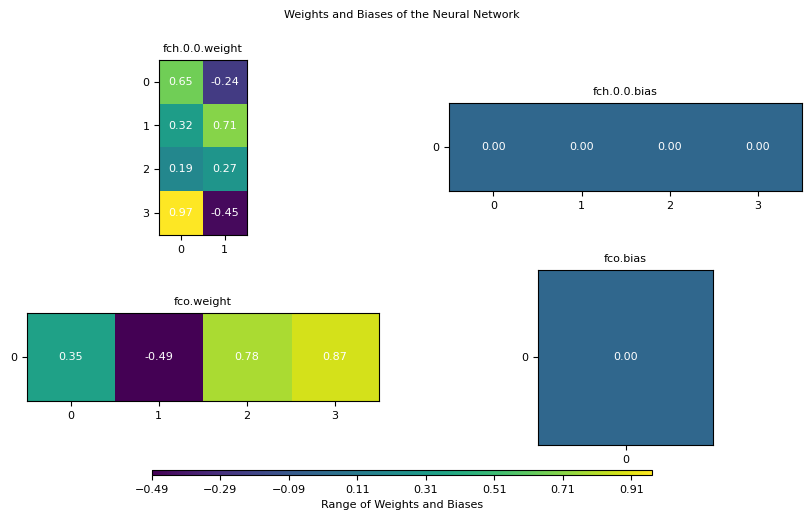

In [10]:
original_input_size = 2
original_hidden_layers = [4]
original_output_size = 1
original_model = FCN(original_input_size, original_hidden_layers, original_output_size, activation='Tanh', initialization='Xavier')
#original_model.plot_weights()

### Checking the model using test points and a constant mu value:

In [ ]:
test_mu = 5
test_in_t_constant_mu = torch.stack([torch.linspace(0,1,point_resolution_test), test_mu*torch.ones(point_resolution_test)], -1).view(-1,2)
#print(f" Point seed list for mesh grid domain points: \n \t {test_in_t_constant_mu}")
#print(f"Size of Domain training points: \n \t {test_in_t_constant_mu.size()}")

In [ ]:
# NO es necesario porque se mantiene constante mu
#test_domain_t_constant_mu = torch.stack(torch.meshgrid(*test_in_t_constant_mu, indexing='ij'), -1).view(-1, 2)
#test_domain_t_constant_mu.size()
#print(f"Domain training points: \n \t: {test_domain_t_constant_mu}")

In [ ]:
test_predicted = original_model(test_in_t_constant_mu)
#test_predicted.size()
#test_predicted

In [ ]:
plt.figure(figsize=(10,2.5))
plt.plot(test_physic_in_t_mu[0].detach(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6
)
plt.plot(test_physic_in_t_mu[0], 
                 test_predicted[:,0].detach(), 
                 label="PINN solution (initial)", 
                 color="tab:green"
)
plt.scatter(
        test_physic_in_t_mu[0], 
        torch.zeros_like(test_physic_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:green",
        alpha=0.6,
        label= "Seed points(testing)"
)
plt.scatter(
        physic_in_t_mu[0].detach(), 
        torch.zeros_like(physic_in_t_mu[0]), 
        s=20, 
        lw=0, 
        color="tab:purple",
        alpha=0.6,
        label= "Training points"
)
### model and activation has to be manually adapted
plt.title(f"Exact and predicted solution for a nn with following architecture: [{original_input_size}, {original_hidden_layers}, {original_output_size}] \n u(t=(0,1), $\mu$ = {test_mu}), model: {original_model.__class__.__name__}, activation function: {original_model.activation}, epoch = 1")
plt.legend()
plt.show()

## STEP 4: Training the PINN

####################################################################################################


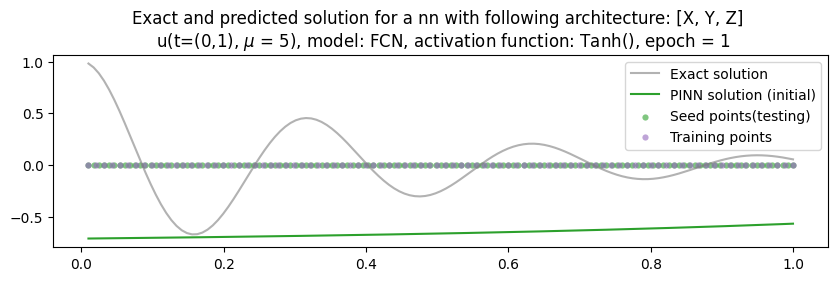

########################################################################################################################################################################################################
PLOTTING THE RESULTS FOR EPOCH: 1000
max_min_amplitude = 0.11254924535751343
Decomposition of the loss terms: 
 loss(0.8625213503837585) = loss1(0.7115243077278137) + 1 * loss2(0.05040302127599716) + 0.0001 * loss3(1005.940673828125)


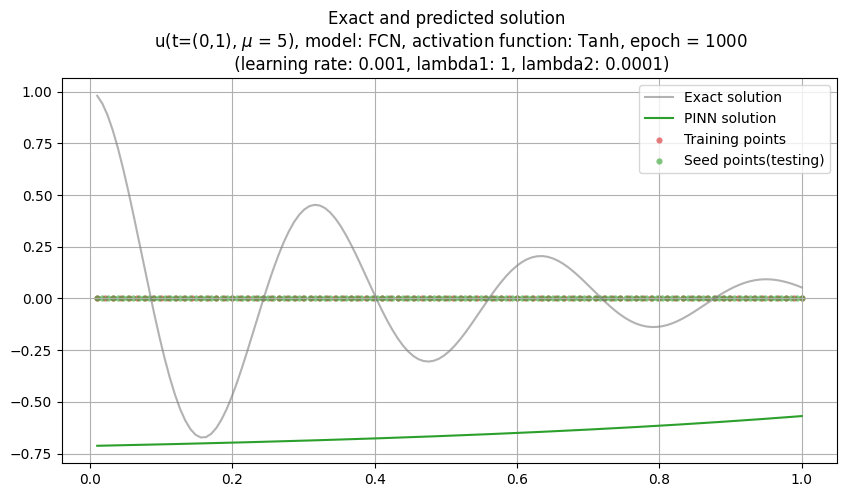

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


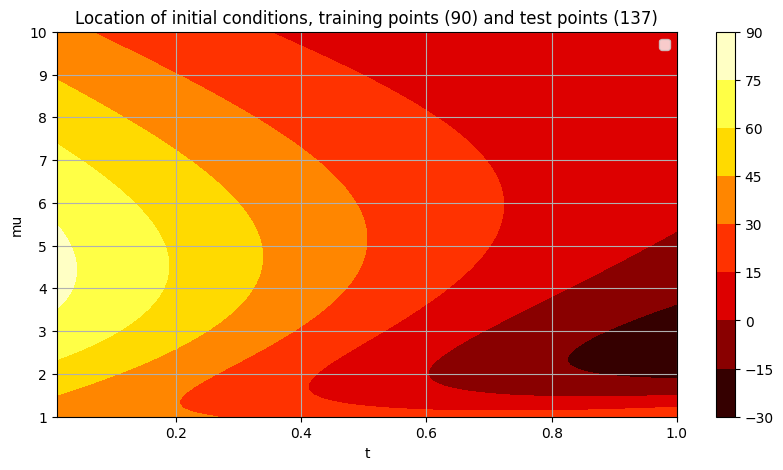

Saved the checkpoint corresponding to epoch: 1000
RESULTS PLOTTED FOR EPOCH: 1000
########################################################################################################################################################################################################
########################################################################################################################################################################################################
PLOTTING THE RESULTS FOR EPOCH: 2000
max_min_amplitude = 0.013271152973175049
Decomposition of the loss terms: 
 loss(0.8358107805252075) = loss1(0.6744032502174377) + 1 * loss2(0.03586064279079437) + 0.0001 * loss3(1255.46875)


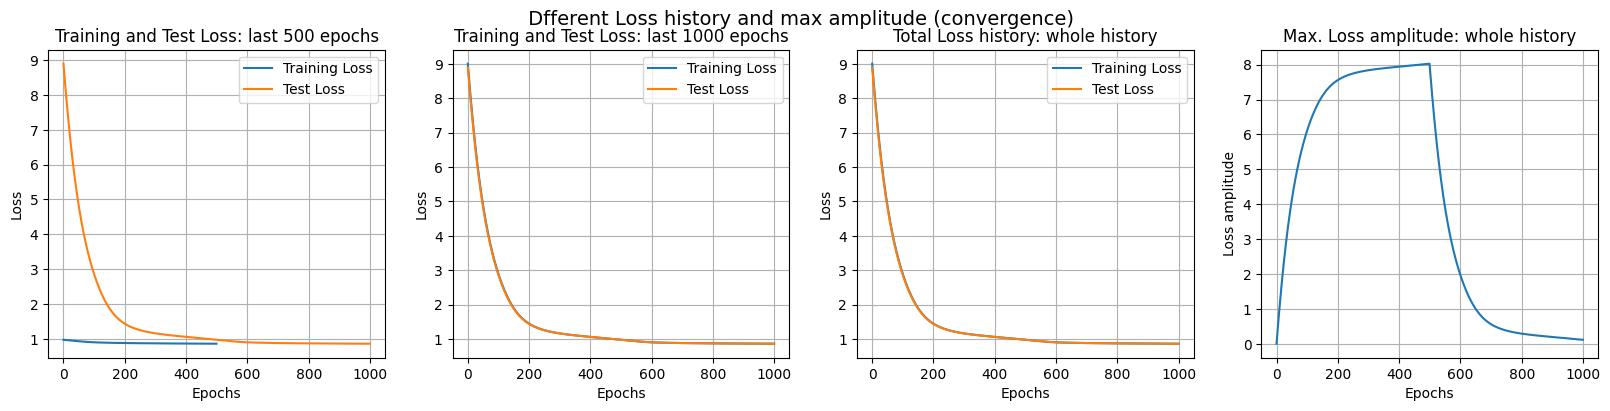

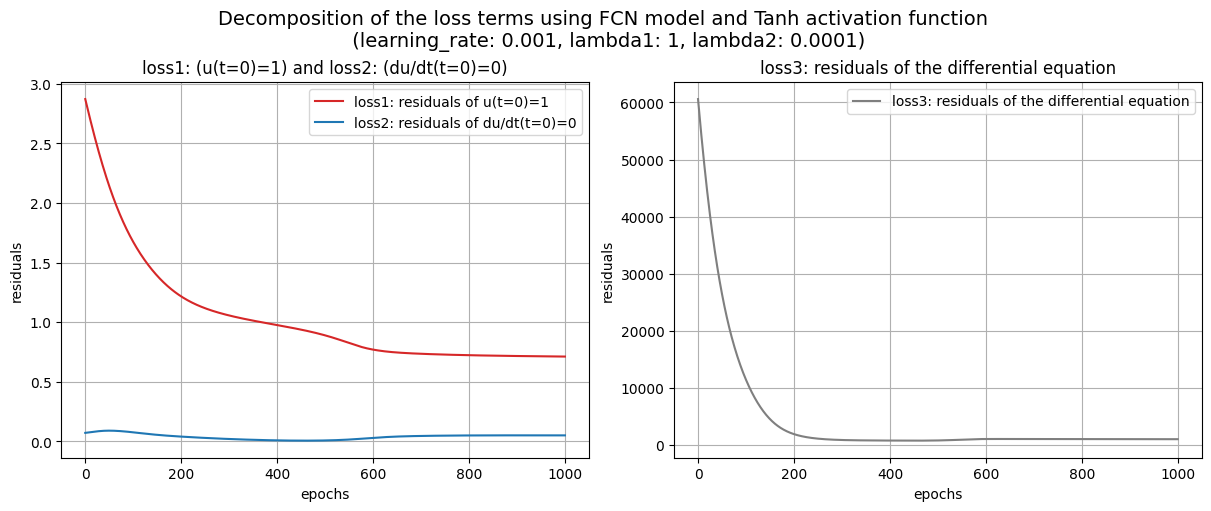

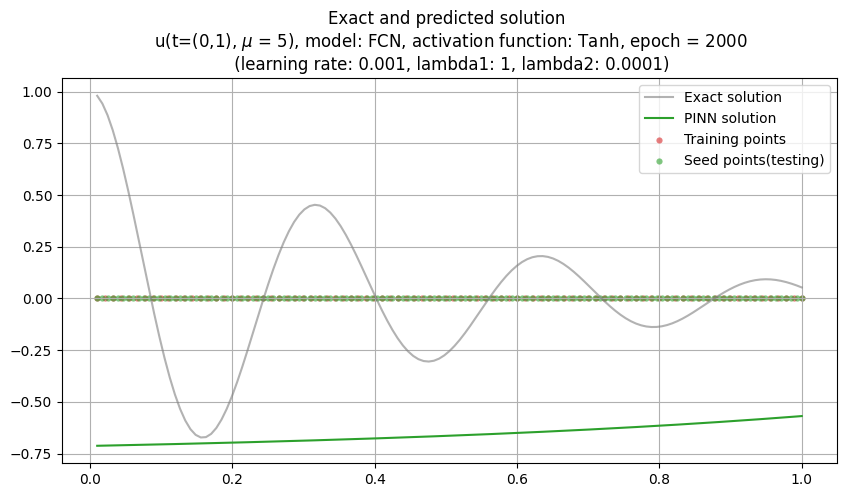

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


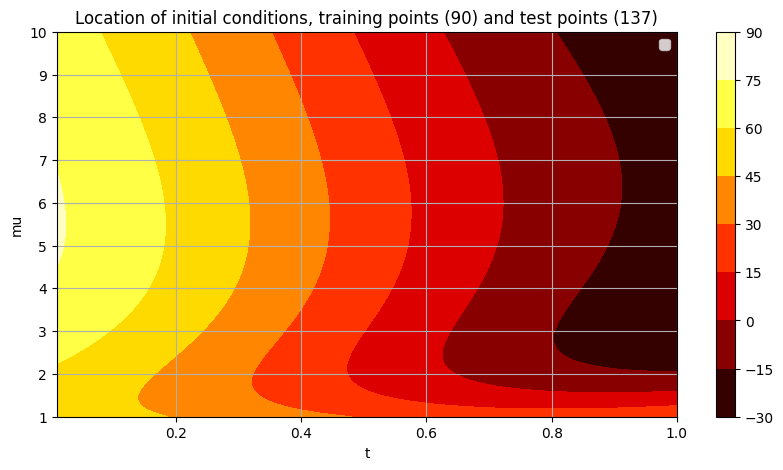

Saved the checkpoint corresponding to epoch: 2000
RESULTS PLOTTED FOR EPOCH: 2000
########################################################################################################################################################################################################
########################################################################################################################################################################################################
PLOTTING THE RESULTS FOR EPOCH: 3000
max_min_amplitude = 0.03779870271682739
Decomposition of the loss terms: 
 loss(0.7748321294784546) = loss1(0.6195958256721497) + 1 * loss2(0.02161363884806633) + 0.0001 * loss3(1336.226806640625)


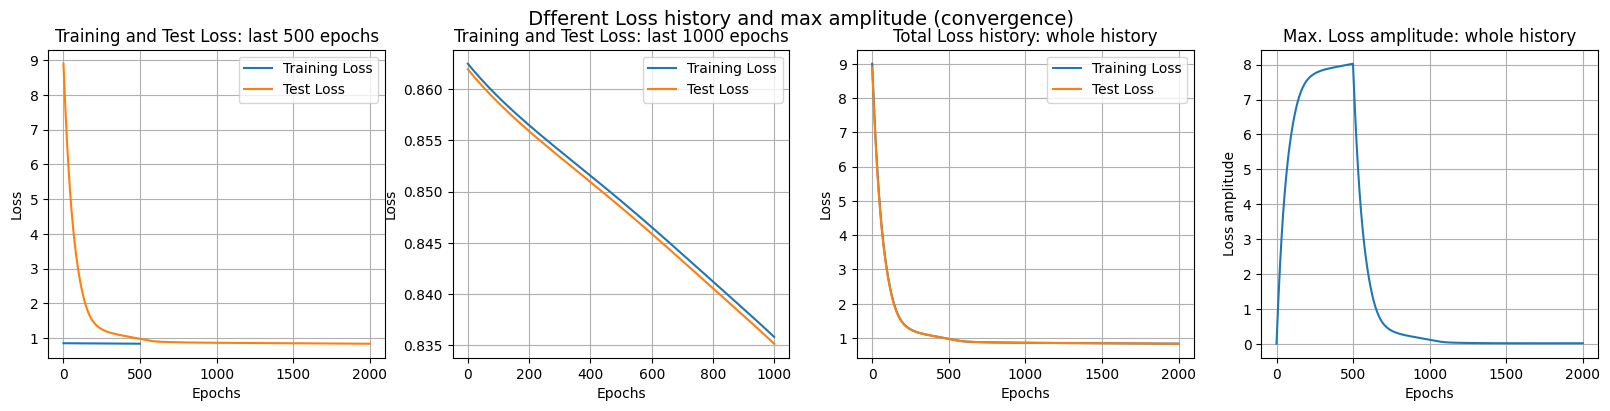

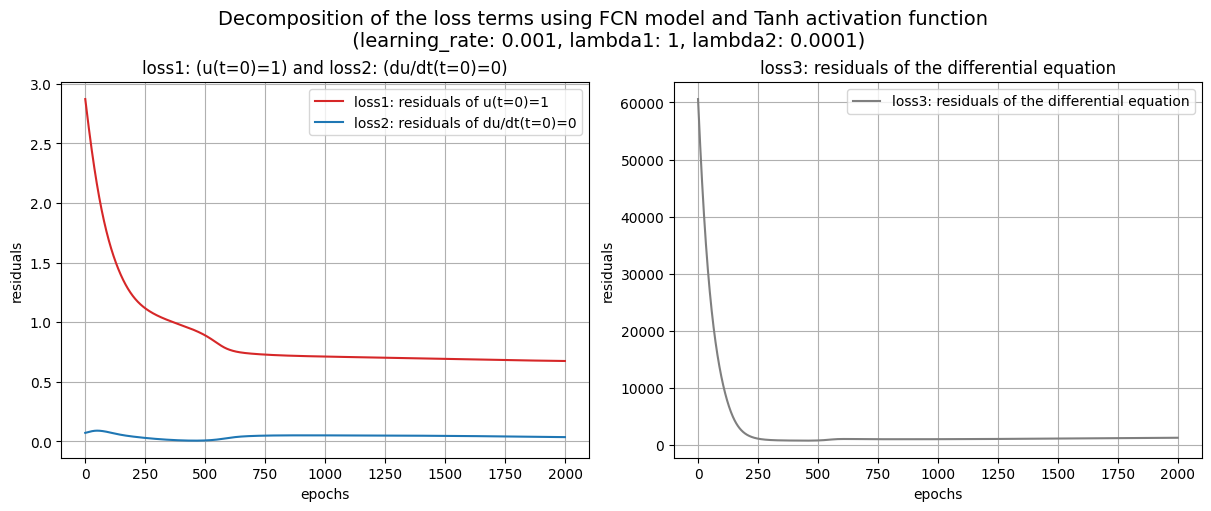

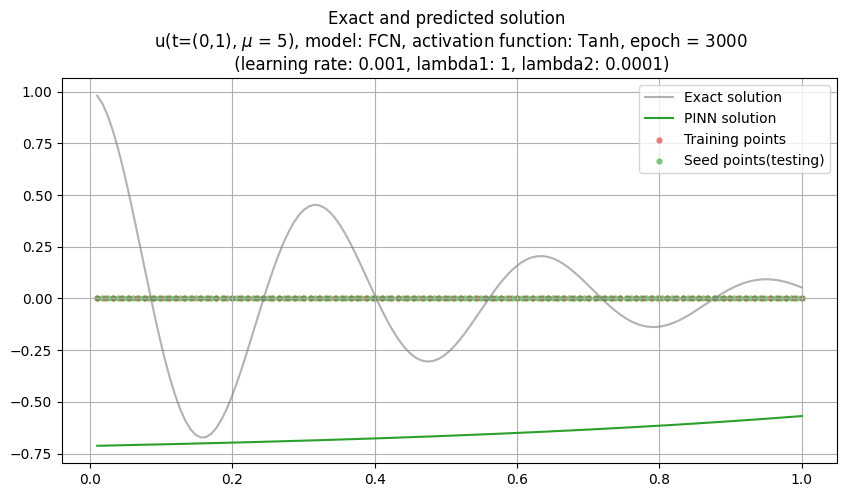

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


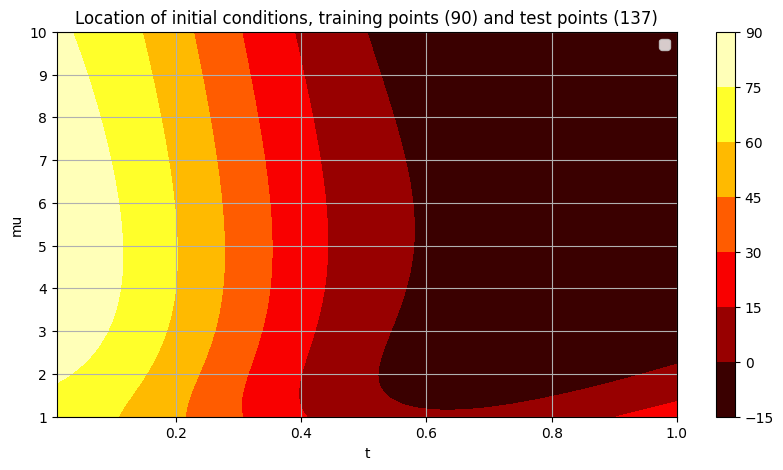

Saved the checkpoint corresponding to epoch: 3000
RESULTS PLOTTED FOR EPOCH: 3000
########################################################################################################################################################################################################
########################################################################################################################################################################################################
PLOTTING THE RESULTS FOR EPOCH: 4000
max_min_amplitude = 0.04278576374053955
Decomposition of the loss terms: 
 loss(0.6941823363304138) = loss1(0.5280495285987854) + 1 * loss2(0.010145544074475765) + 0.0001 * loss3(1559.872802734375)


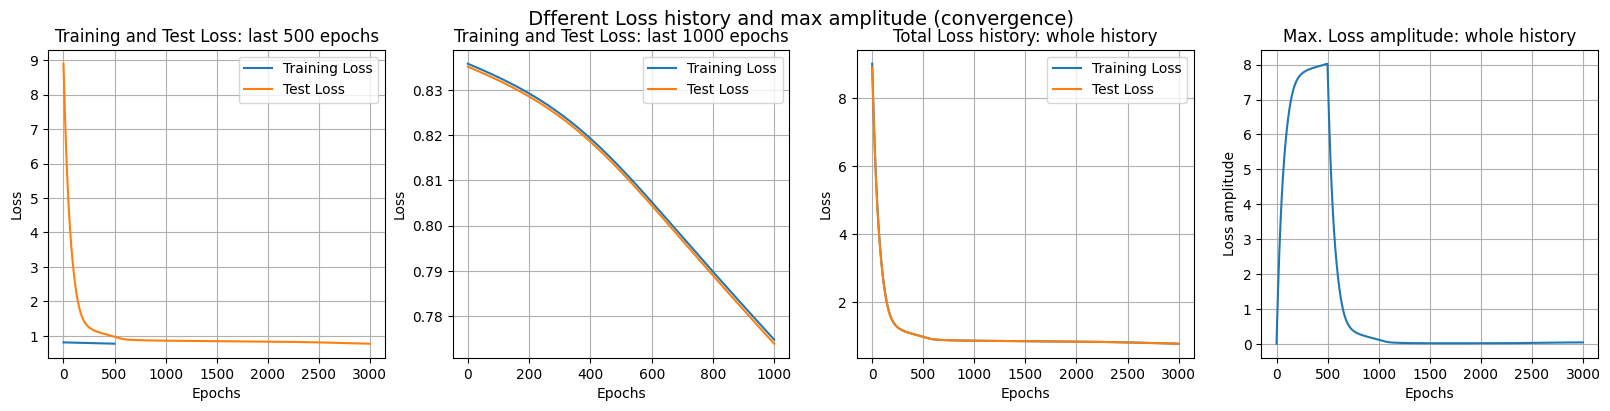

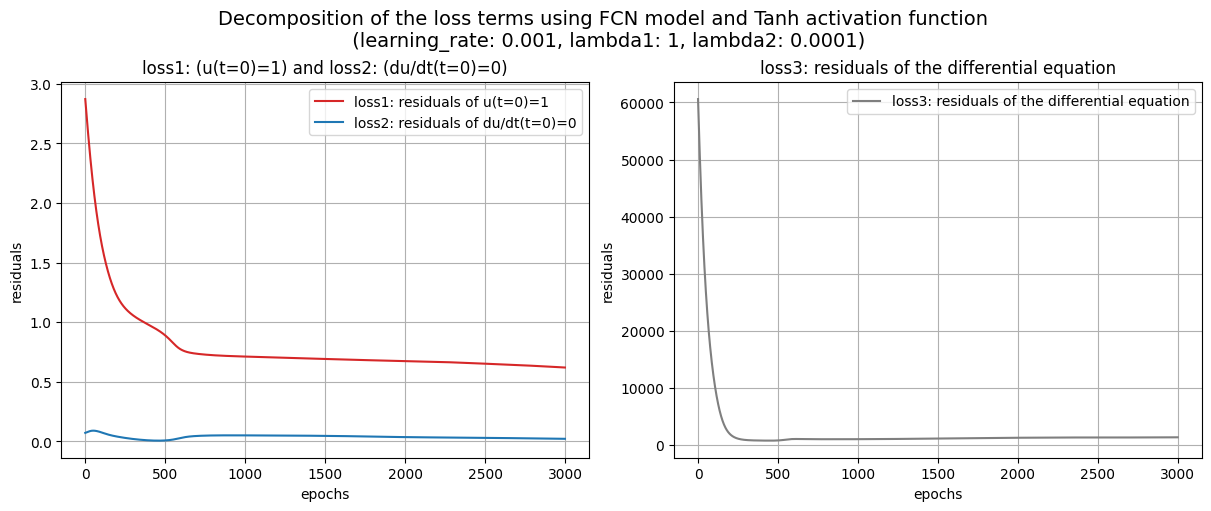

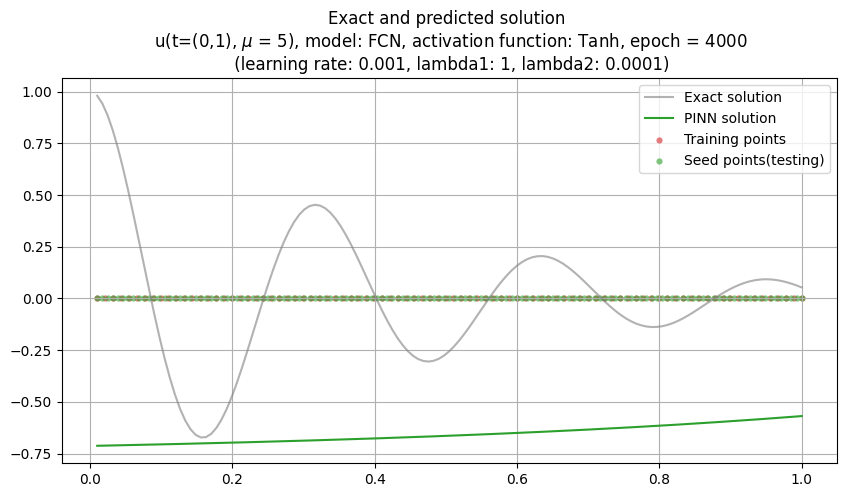

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


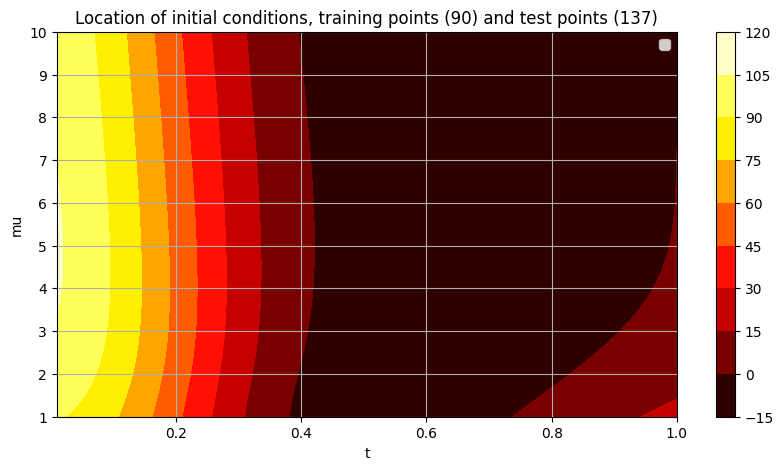

Saved the checkpoint corresponding to epoch: 4000
RESULTS PLOTTED FOR EPOCH: 4000
########################################################################################################################################################################################################
########################################################################################################################################################################################################
PLOTTING THE RESULTS FOR EPOCH: 5000
max_min_amplitude = 0.053966522216796875
Decomposition of the loss terms: 
 loss(0.5907942056655884) = loss1(0.4105397164821625) + 1 * loss2(0.0036223321221768856) + 0.0001 * loss3(1766.321533203125)


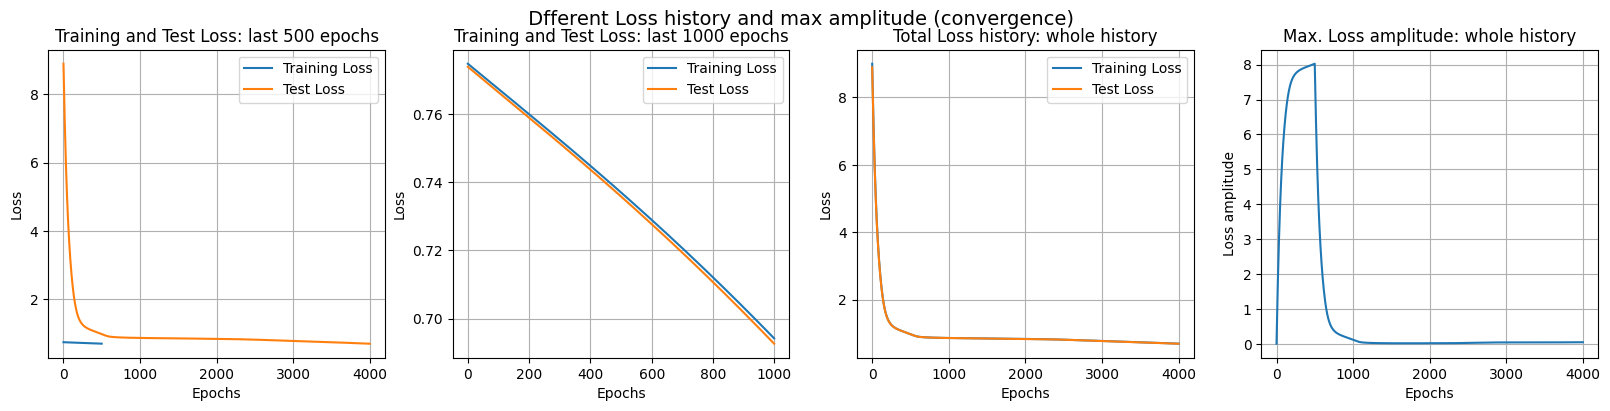

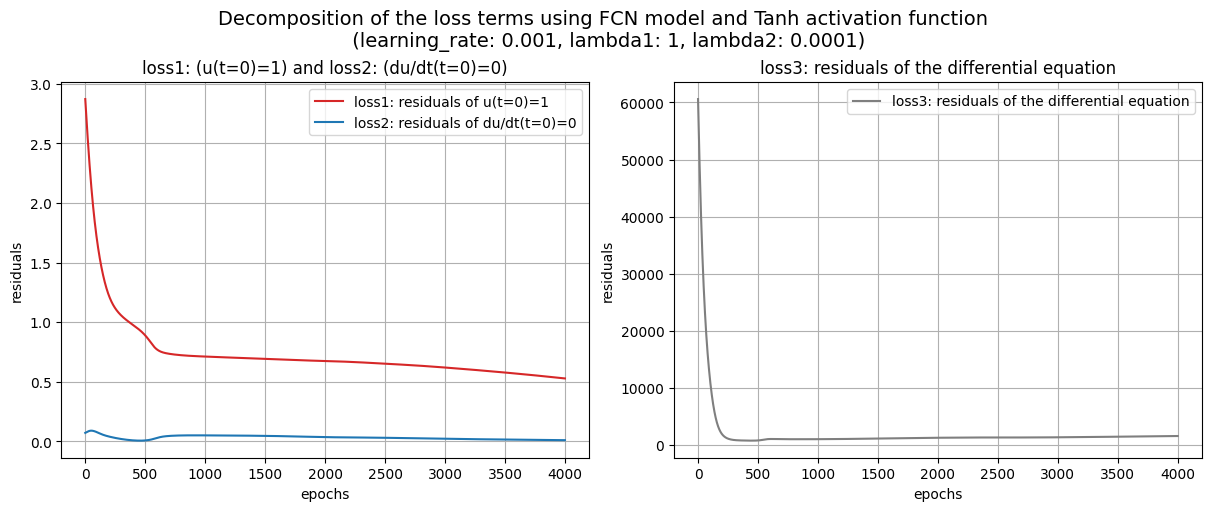

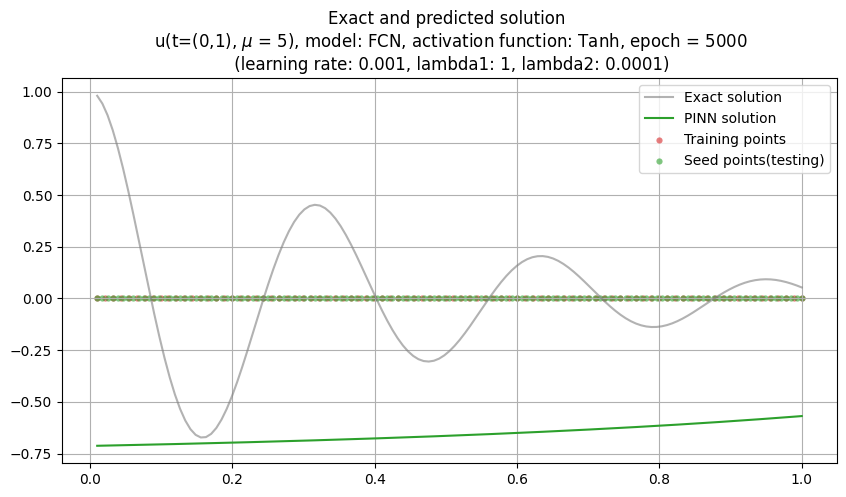

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


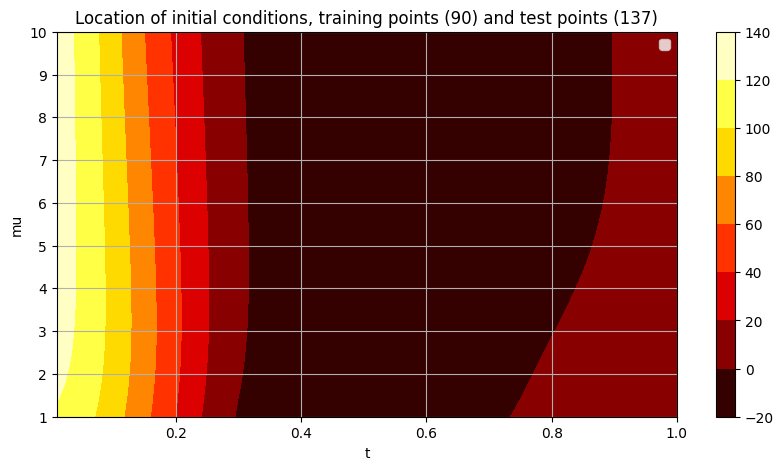

Saved the checkpoint corresponding to epoch: 5000
RESULTS PLOTTED FOR EPOCH: 5000
########################################################################################################################################################################################################
########################################################################################################################################################################################################
PLOTTING THE RESULTS FOR EPOCH: 6000
max_min_amplitude = 0.05832332372665405
Decomposition of the loss terms: 
 loss(0.47542792558670044) = loss1(0.29249271750450134) + 1 * loss2(0.0011987828183919191) + 0.0001 * loss3(1817.3643798828125)


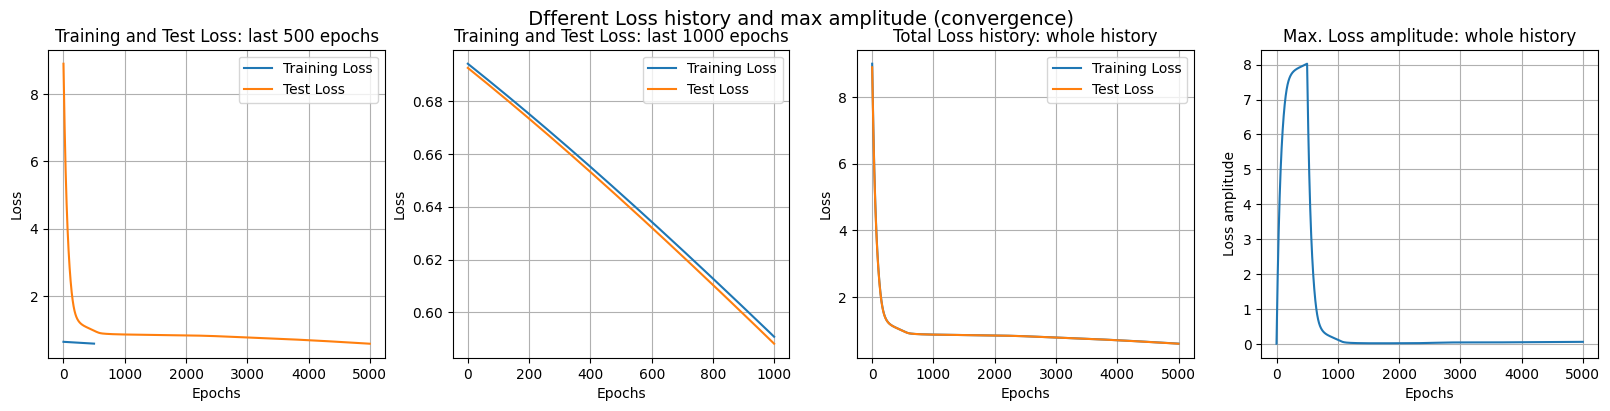

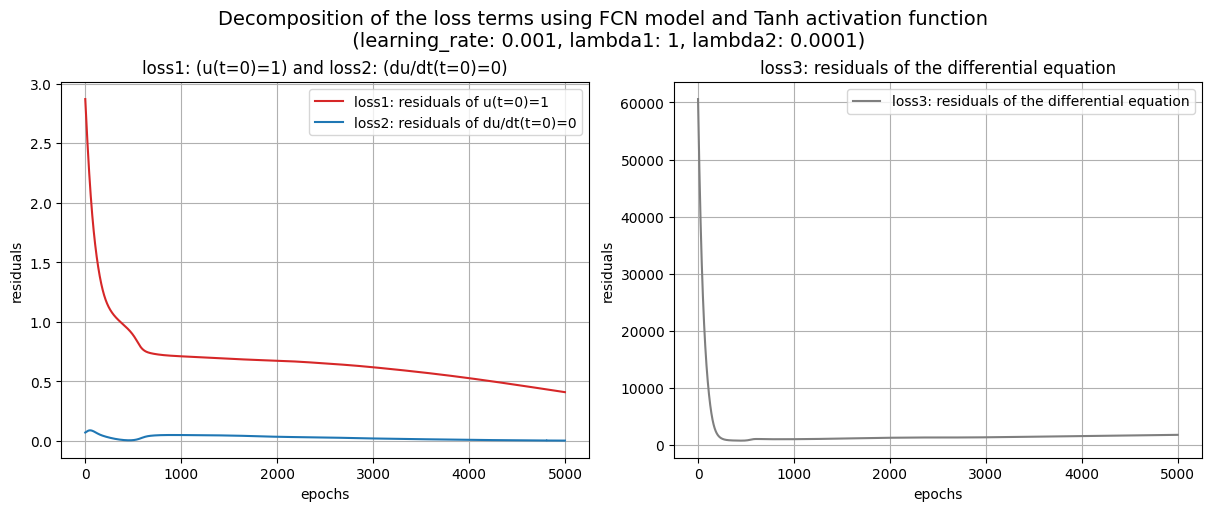

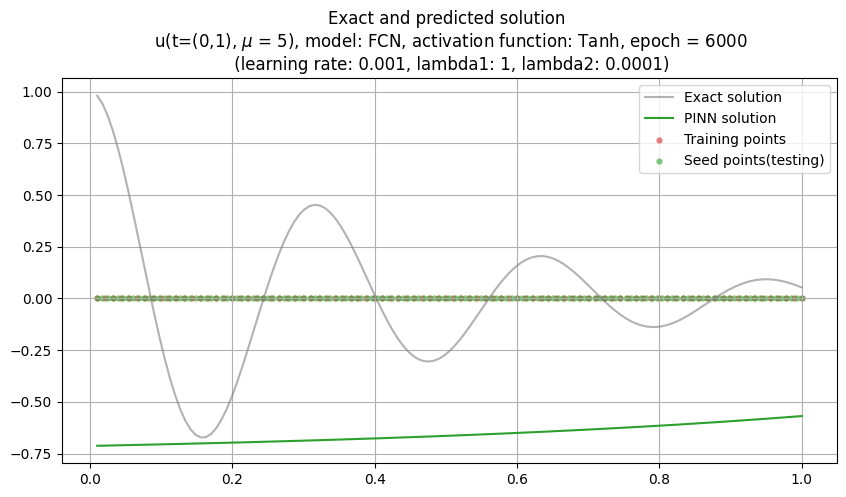

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


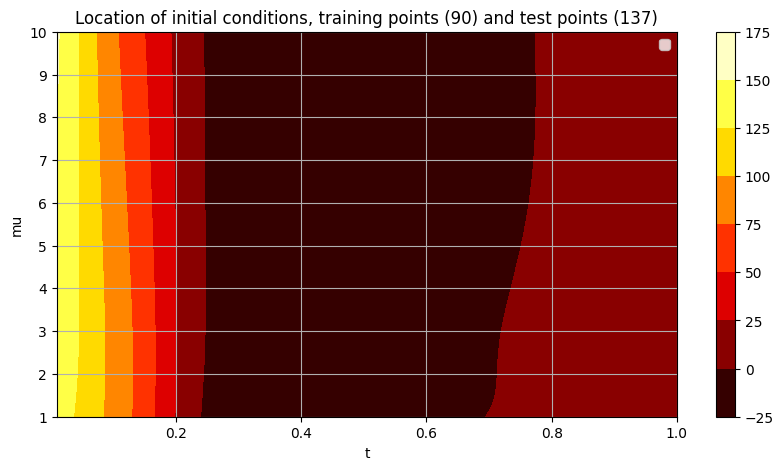

Saved the checkpoint corresponding to epoch: 6000
RESULTS PLOTTED FOR EPOCH: 6000
########################################################################################################################################################################################################
########################################################################################################################################################################################################
PLOTTING THE RESULTS FOR EPOCH: 7000
max_min_amplitude = 0.057244300842285156
Decomposition of the loss terms: 
 loss(0.3593314290046692) = loss1(0.19016975164413452) + 1 * loss2(0.00044825623626820743) + 0.0001 * loss3(1687.13427734375)


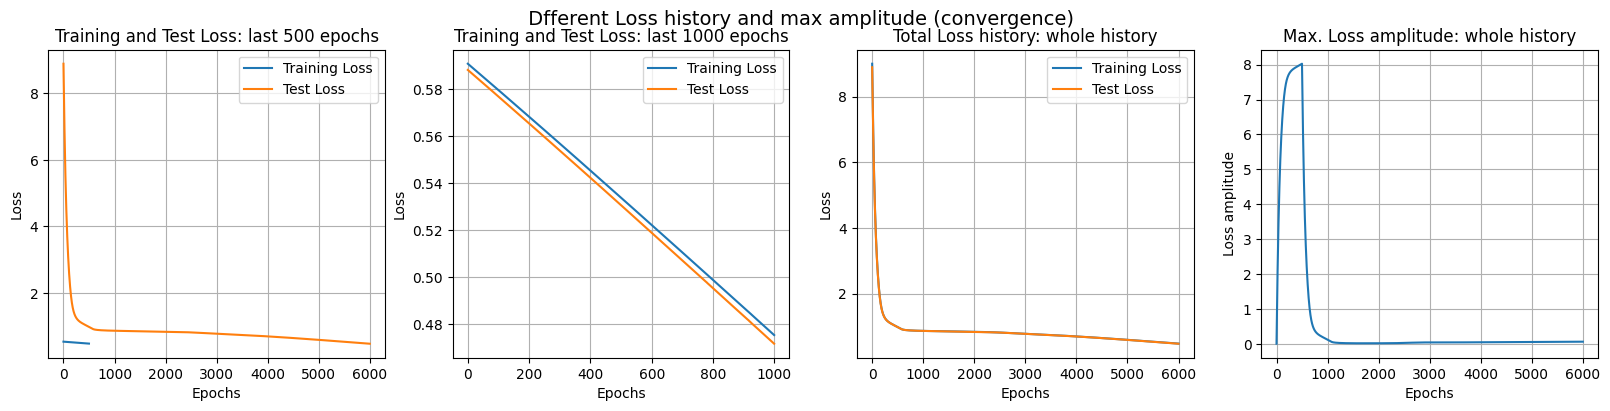

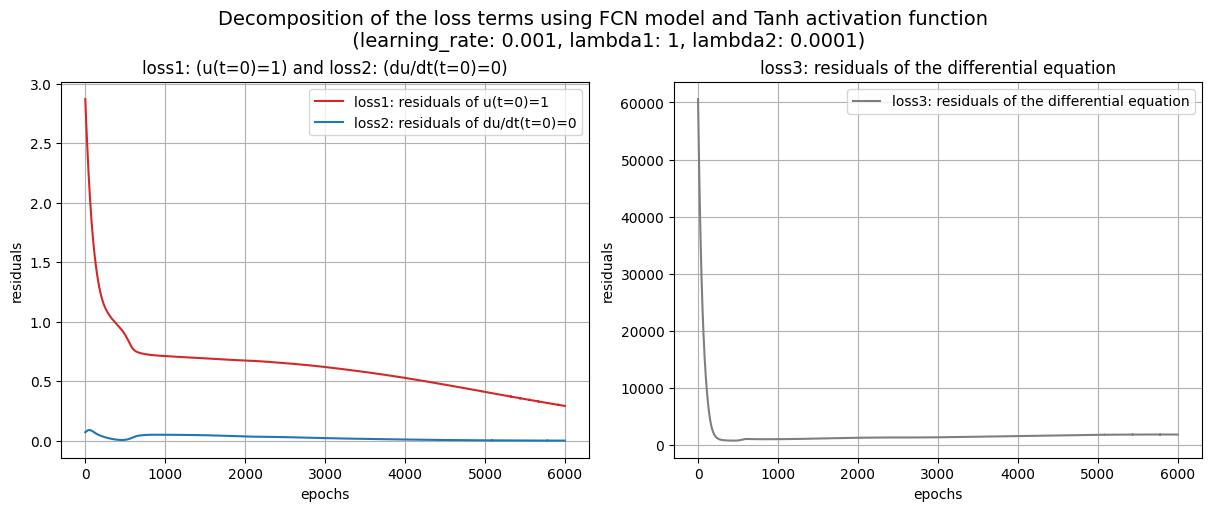

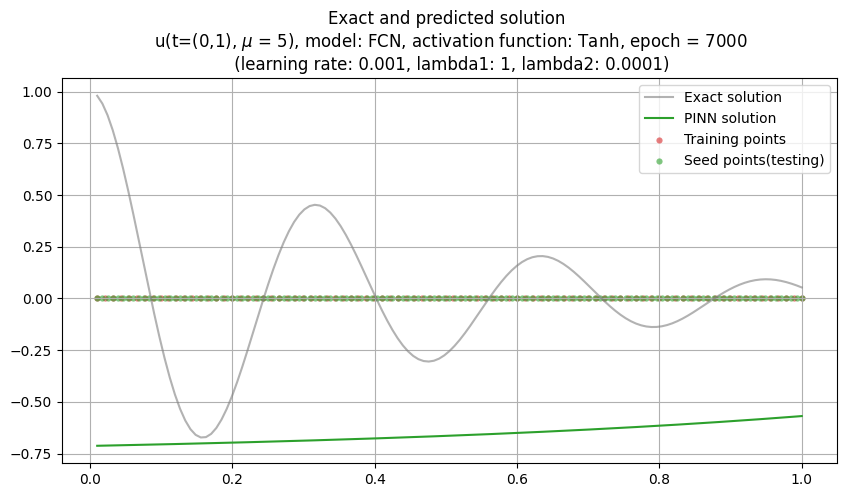

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


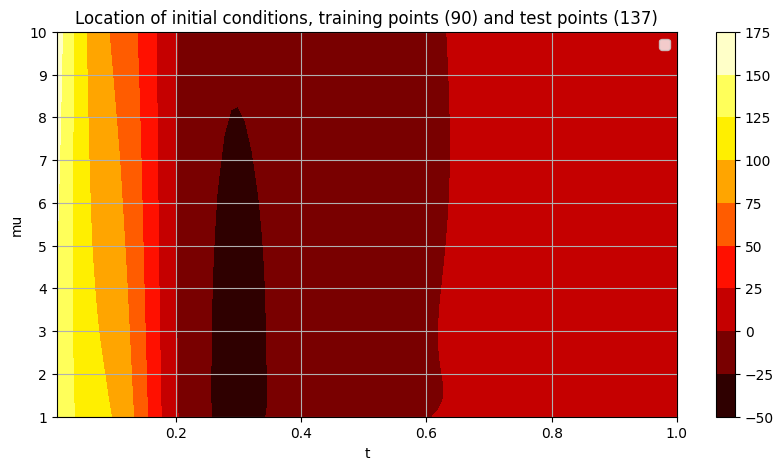

Saved the checkpoint corresponding to epoch: 7000
RESULTS PLOTTED FOR EPOCH: 7000
########################################################################################################################################################################################################
########################################################################################################################################################################################################
PLOTTING THE RESULTS FOR EPOCH: 8000
max_min_amplitude = 0.046756207942962646
Decomposition of the loss terms: 
 loss(0.25891321897506714) = loss1(0.11198721081018448) + 1 * loss2(0.000364103470928967) + 0.0001 * loss3(1465.6190185546875)


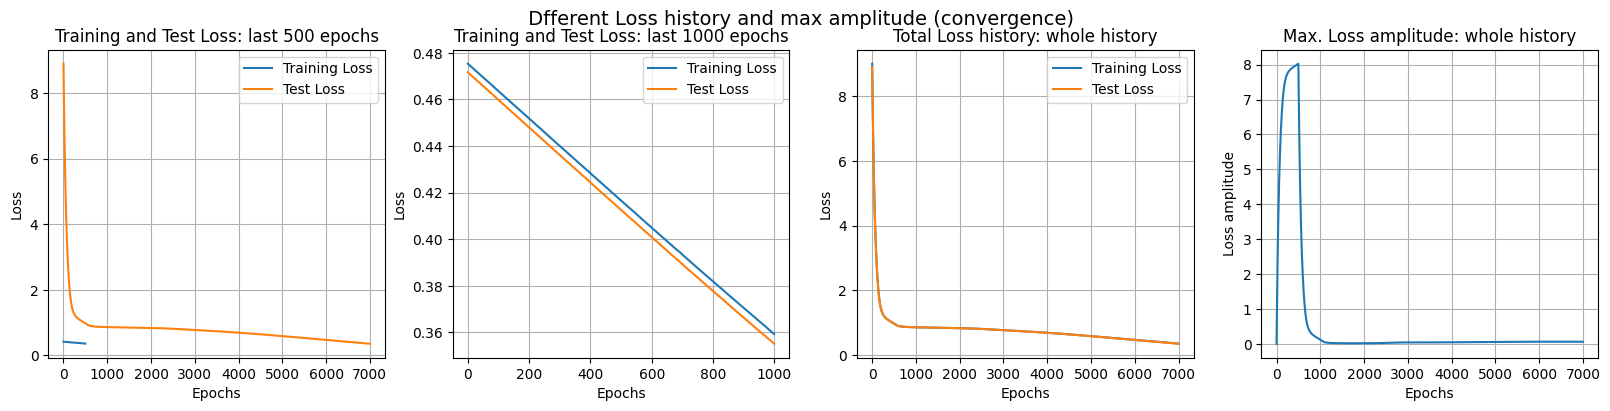

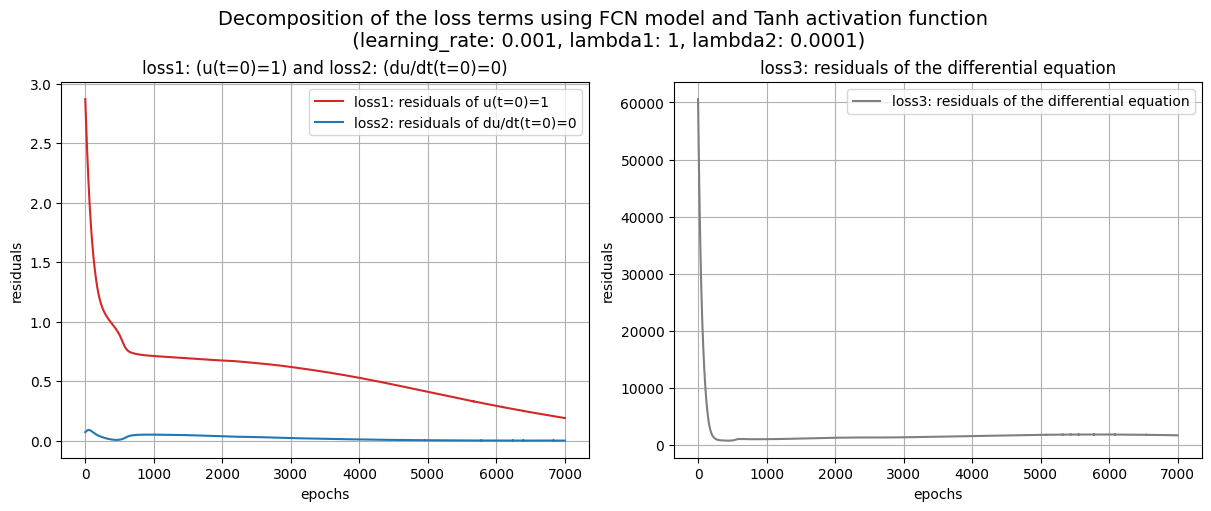

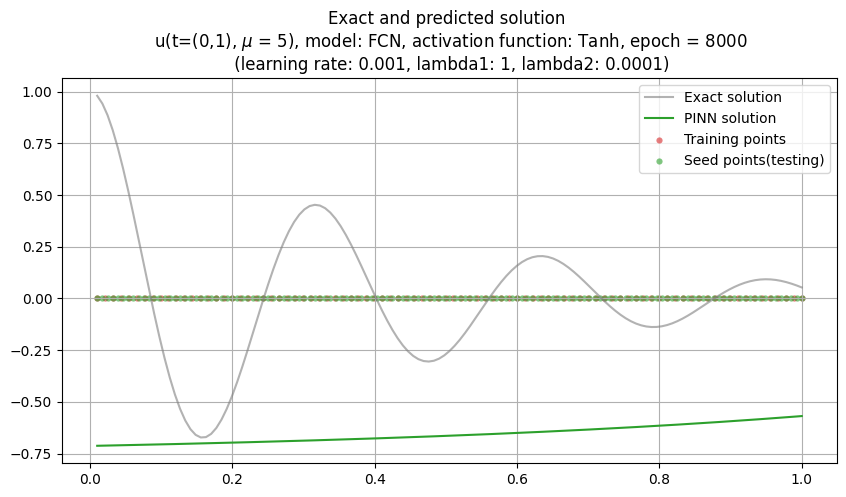

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


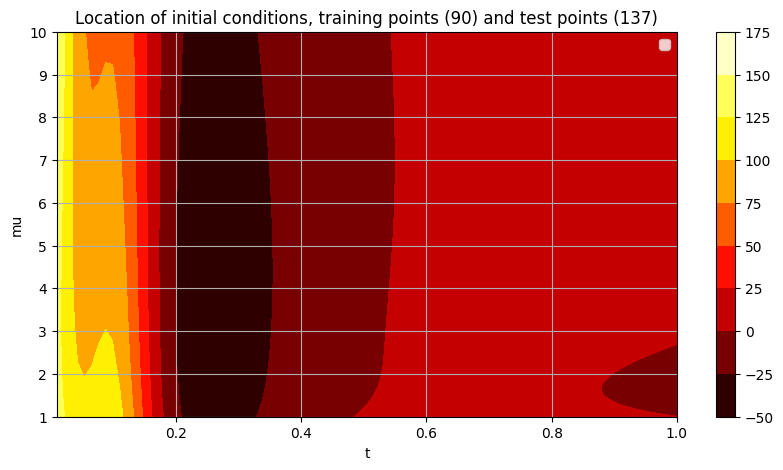

Saved the checkpoint corresponding to epoch: 8000
RESULTS PLOTTED FOR EPOCH: 8000
########################################################################################################################################################################################################
########################################################################################################################################################################################################
PLOTTING THE RESULTS FOR EPOCH: 9000
max_min_amplitude = 0.032239288091659546
Decomposition of the loss terms: 
 loss(0.18808549642562866) = loss1(0.06486567109823227) + 1 * loss2(0.0002026515285251662) + 0.0001 * loss3(1230.171875)


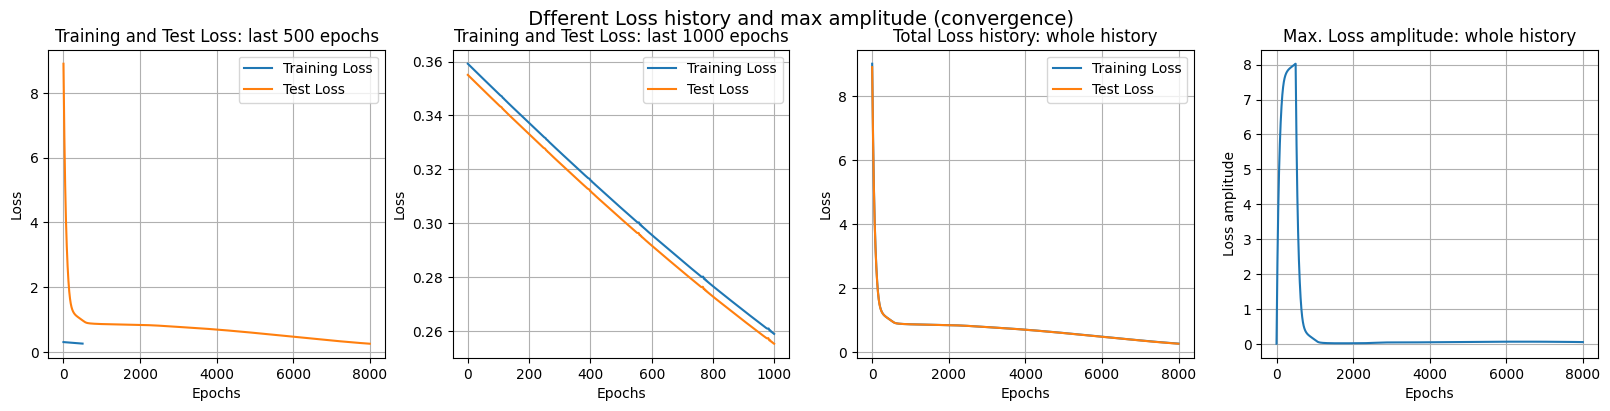

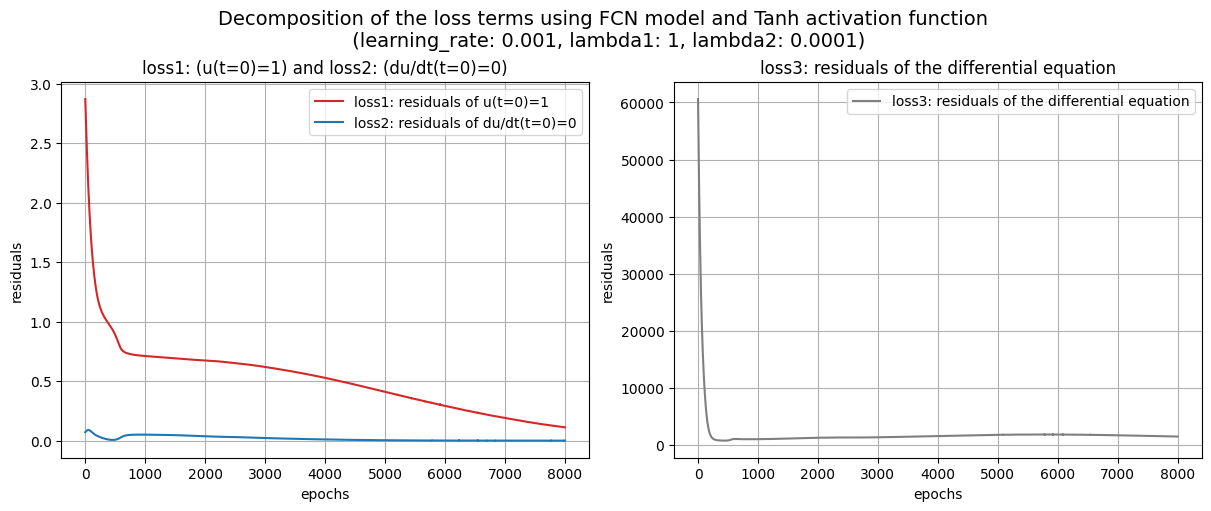

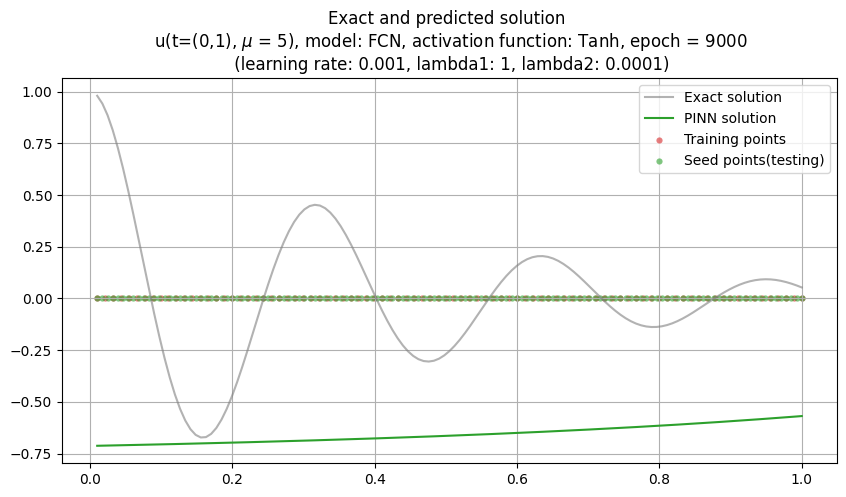

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


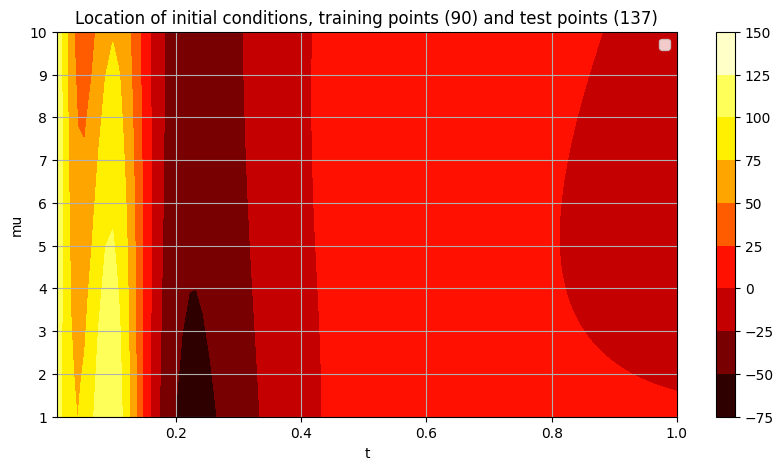

Saved the checkpoint corresponding to epoch: 9000
RESULTS PLOTTED FOR EPOCH: 9000
########################################################################################################################################################################################################
########################################################################################################################################################################################################
PLOTTING THE RESULTS FOR EPOCH: 10000
max_min_amplitude = 0.013053417205810547
Decomposition of the loss terms: 
 loss(0.1553843915462494) = loss1(0.04186318442225456) + 1 * loss2(2.8182874302729033e-05) + 0.0001 * loss3(1134.9302978515625)


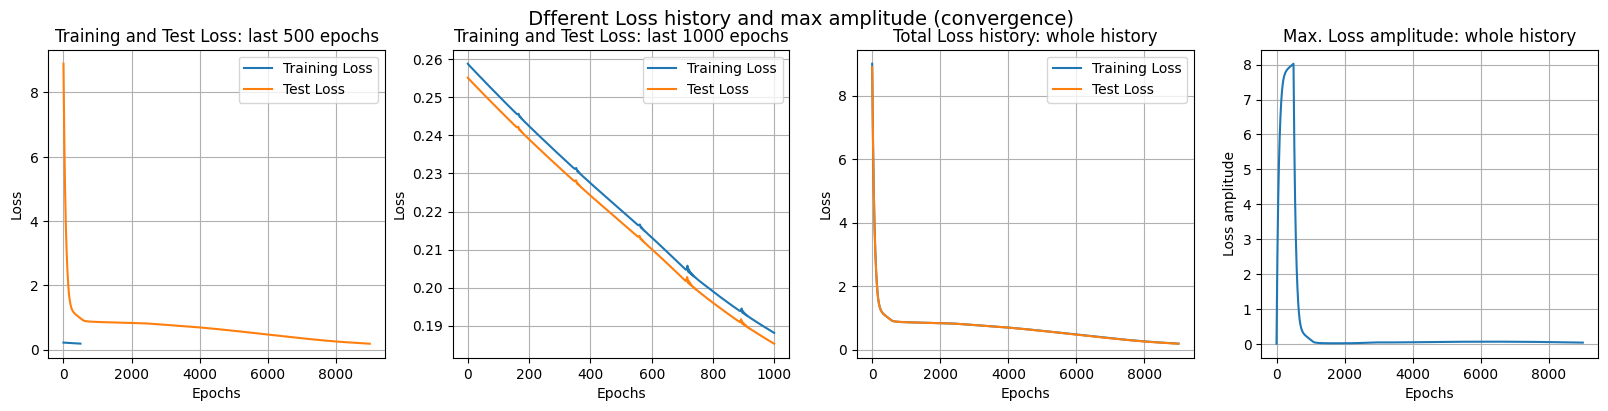

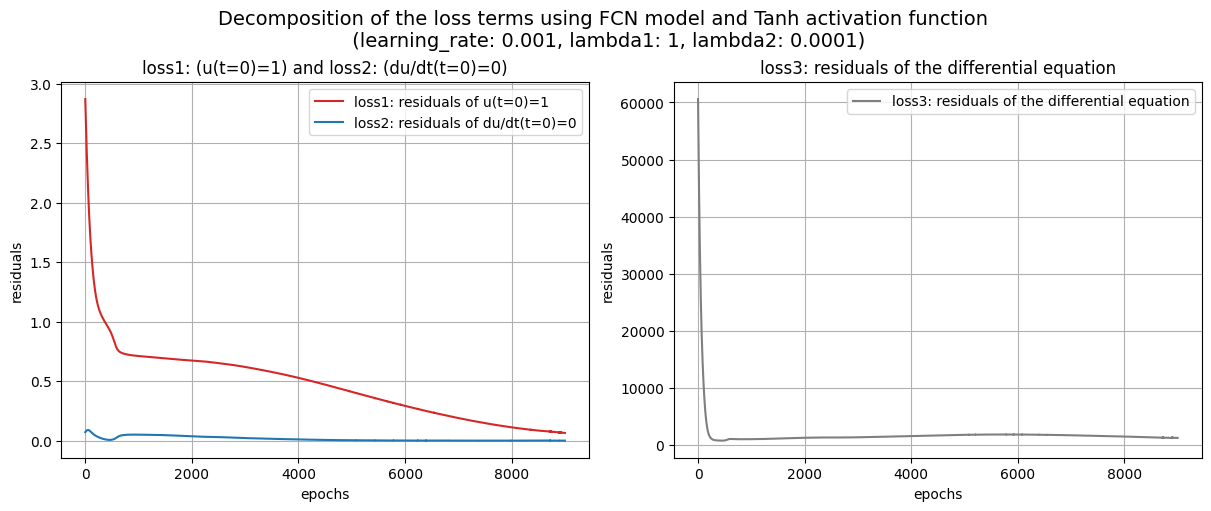

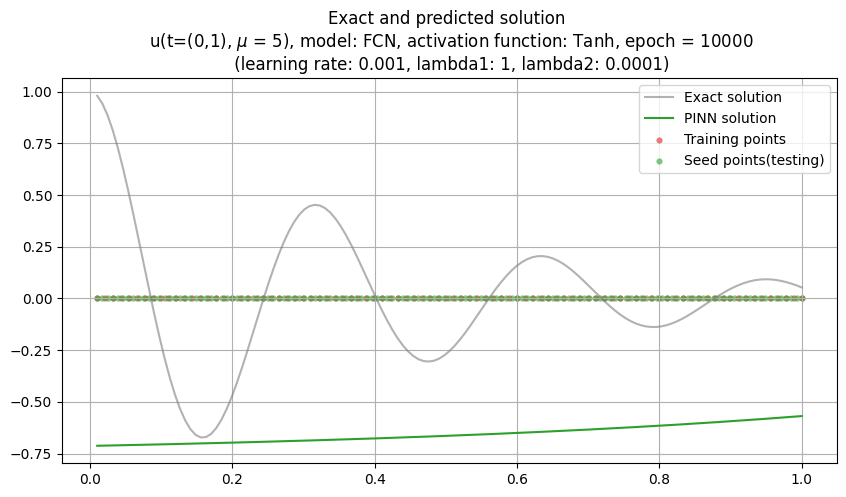

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


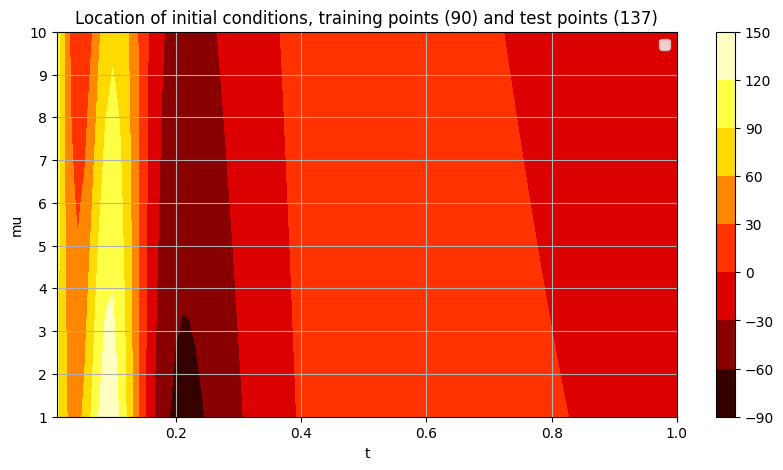

Saved the checkpoint corresponding to epoch: 10000
RESULTS PLOTTED FOR EPOCH: 10000
########################################################################################################################################################################################################
########################################################################################################################################################################################################
PLOTTING THE RESULTS FOR EPOCH: 11000
max_min_amplitude = 0.006003201007843018
Decomposition of the loss terms: 
 loss(0.14255347847938538) = loss1(0.03144014626741409) + 1 * loss2(2.343709820706863e-05) + 0.0001 * loss3(1110.89892578125)


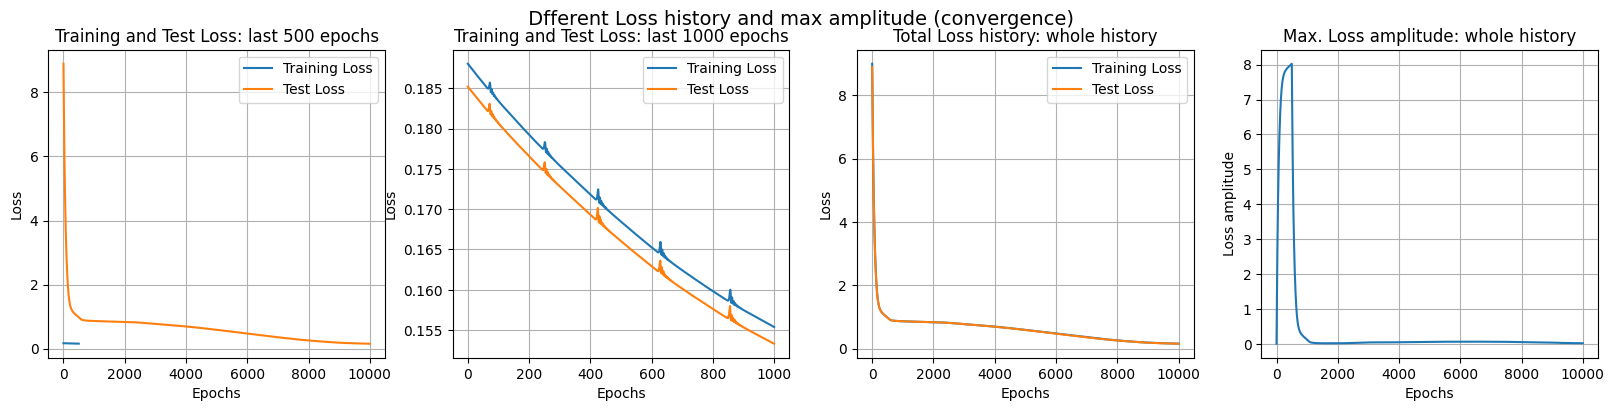

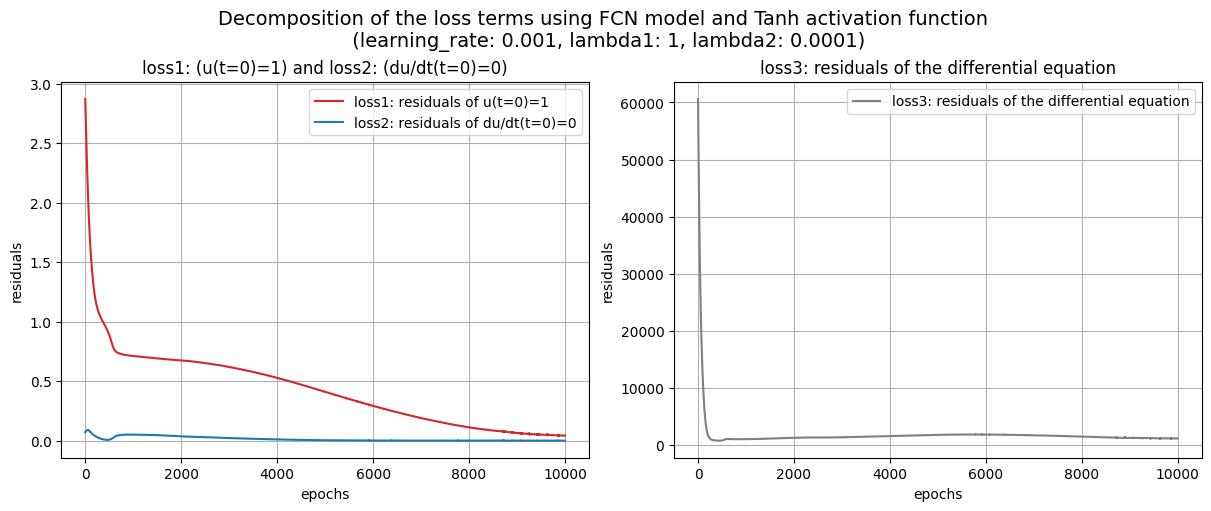

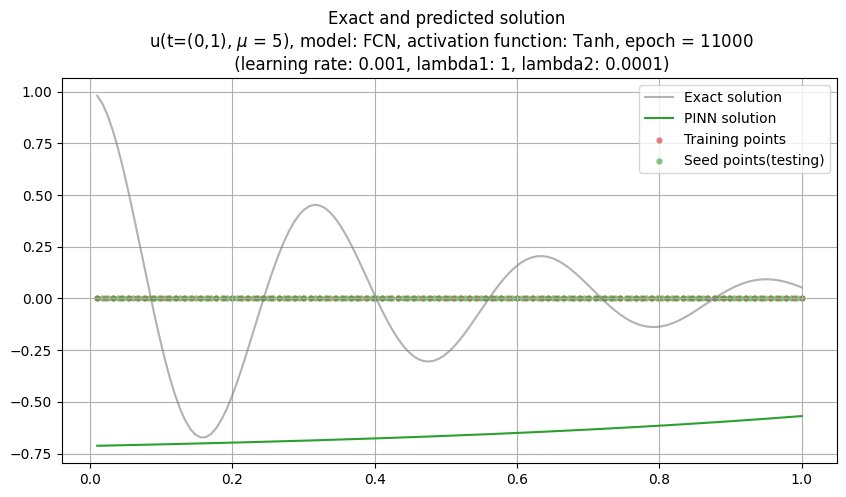

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


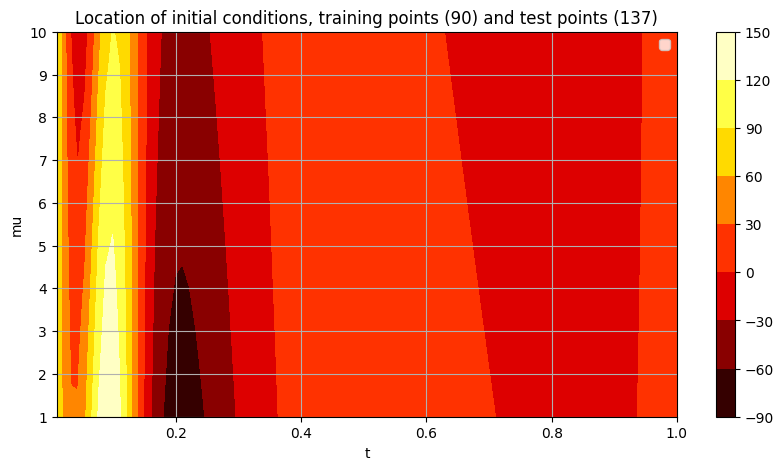

Saved the checkpoint corresponding to epoch: 11000
RESULTS PLOTTED FOR EPOCH: 11000
########################################################################################################################################################################################################
########################################################################################################################################################################################################
PLOTTING THE RESULTS FOR EPOCH: 12000
max_min_amplitude = 0.0032286643981933594
Decomposition of the loss terms: 
 loss(0.1371069997549057) = loss1(0.02664158307015896) + 1 * loss2(1.9049712136620656e-05) + 0.0001 * loss3(1104.4637451171875)


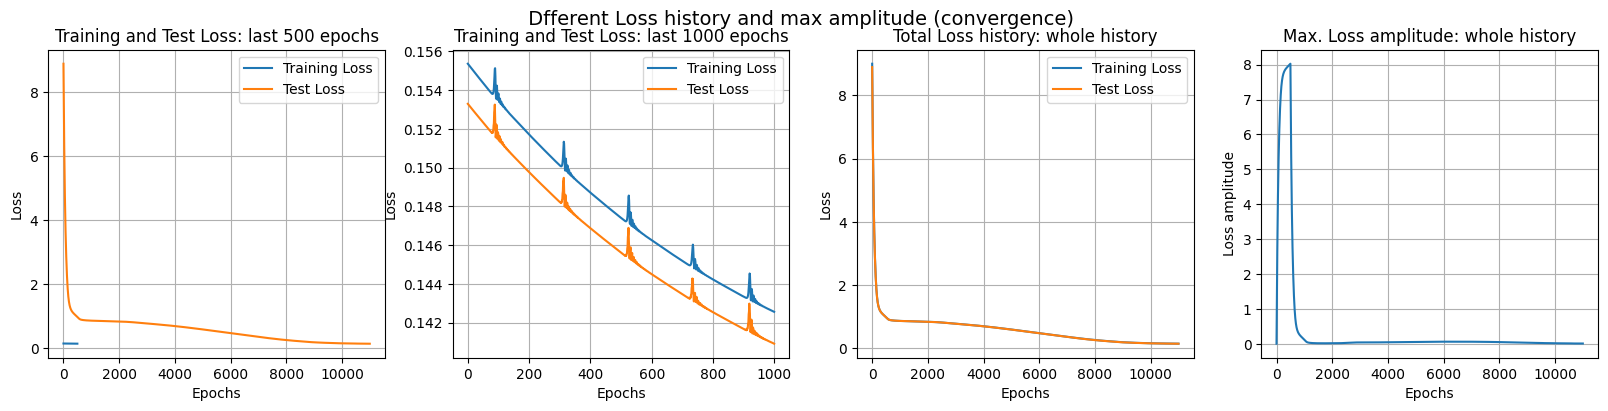

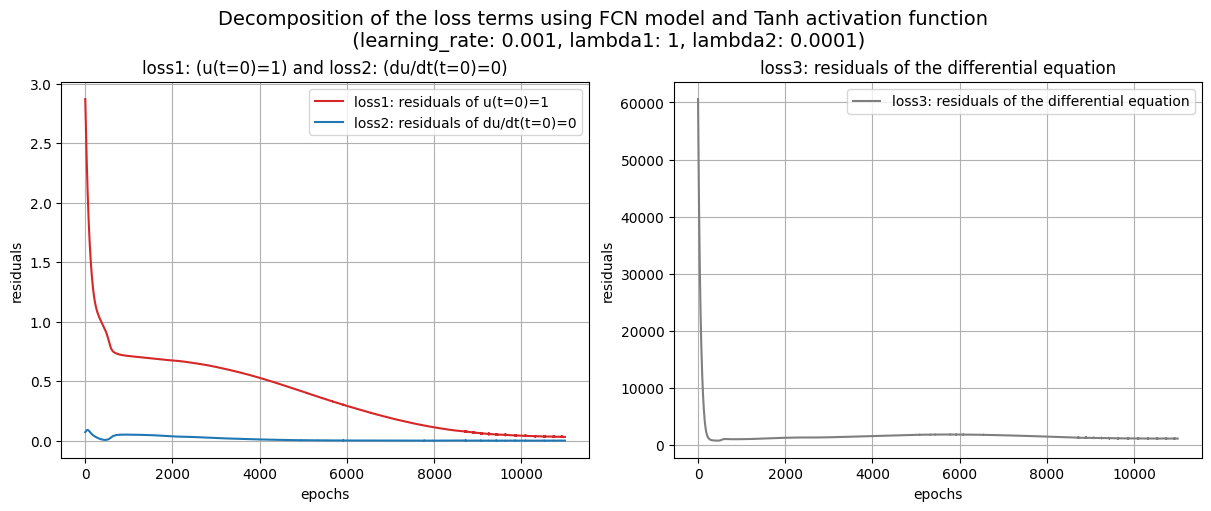

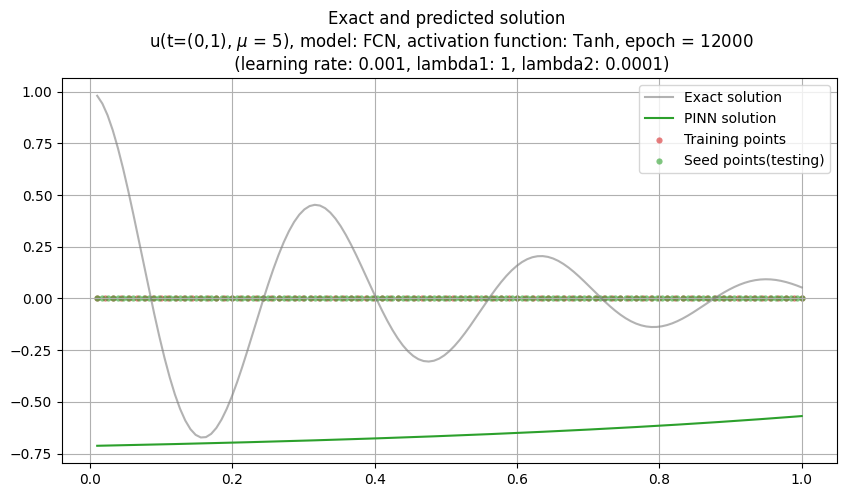

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


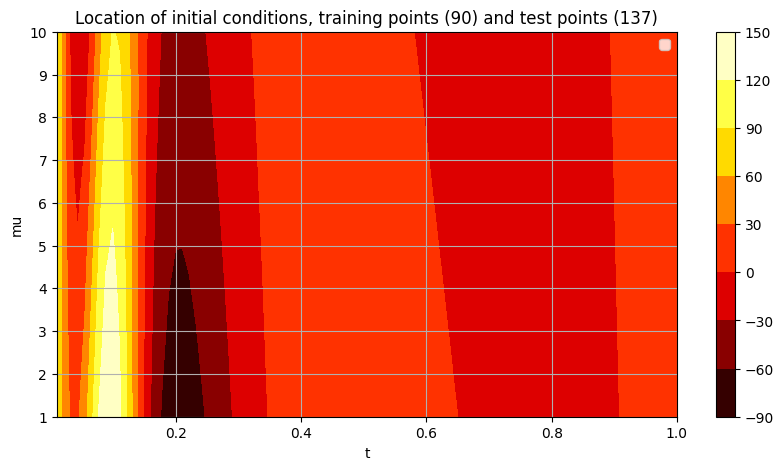

Saved the checkpoint corresponding to epoch: 12000
RESULTS PLOTTED FOR EPOCH: 12000
########################################################################################################################################################################################################
########################################################################################################################################################################################################
PLOTTING THE RESULTS FOR EPOCH: 13000
max_min_amplitude = 0.0031030476093292236
Decomposition of the loss terms: 
 loss(0.1326582282781601) = loss1(0.02494901791214943) + 1 * loss2(1.5812651326996274e-05) + 0.0001 * loss3(1076.93408203125)


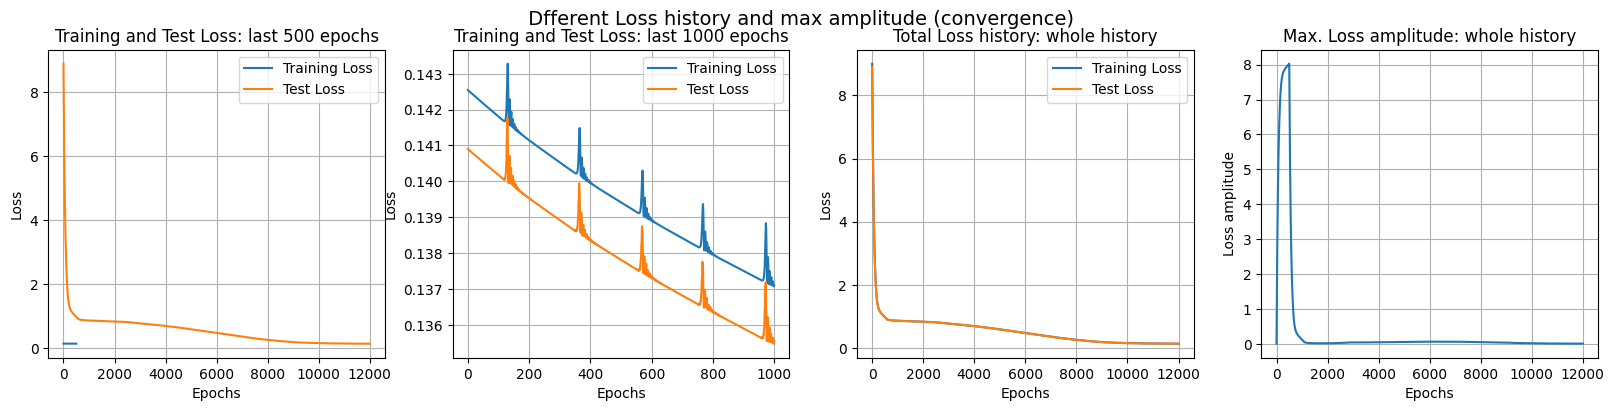

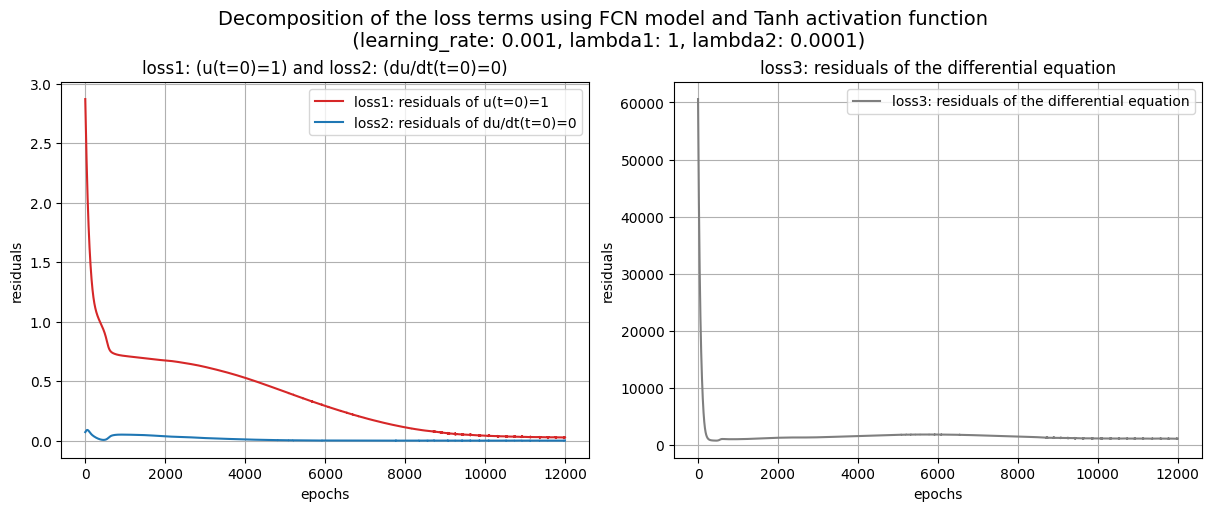

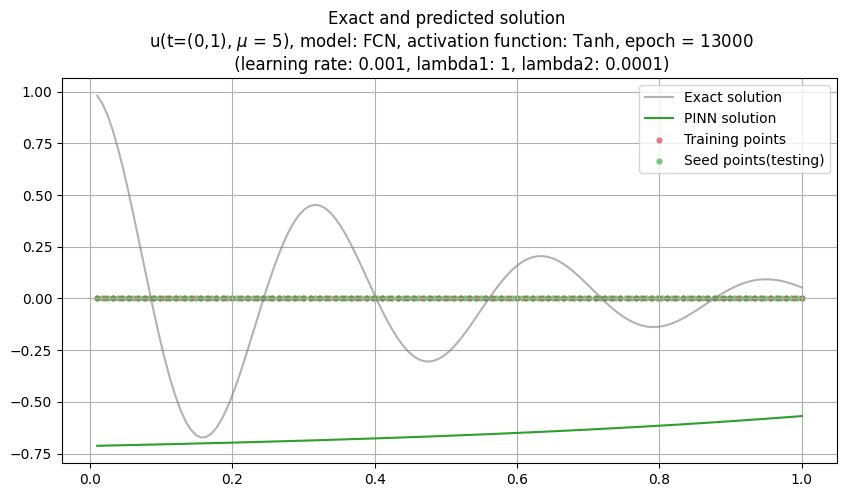

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


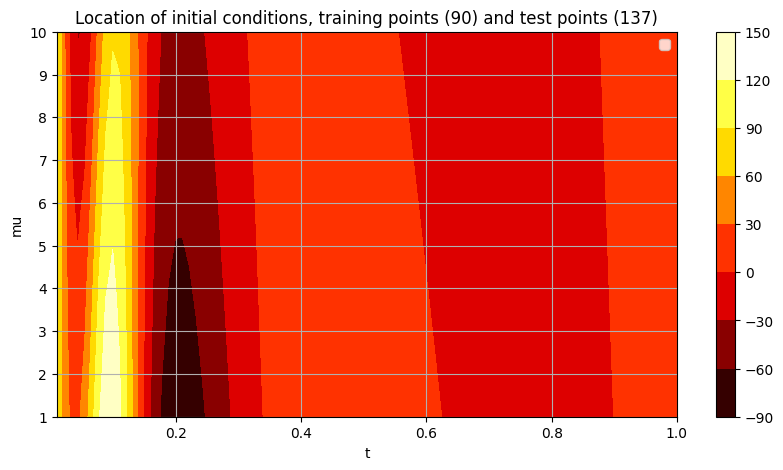

Saved the checkpoint corresponding to epoch: 13000
RESULTS PLOTTED FOR EPOCH: 13000
########################################################################################################################################################################################################
########################################################################################################################################################################################################
PLOTTING THE RESULTS FOR EPOCH: 14000
max_min_amplitude = 0.003974616527557373
Decomposition of the loss terms: 
 loss(0.12701435387134552) = loss1(0.023303691297769547) + 1 * loss2(1.5491903468500823e-05) + 0.0001 * loss3(1036.9517822265625)


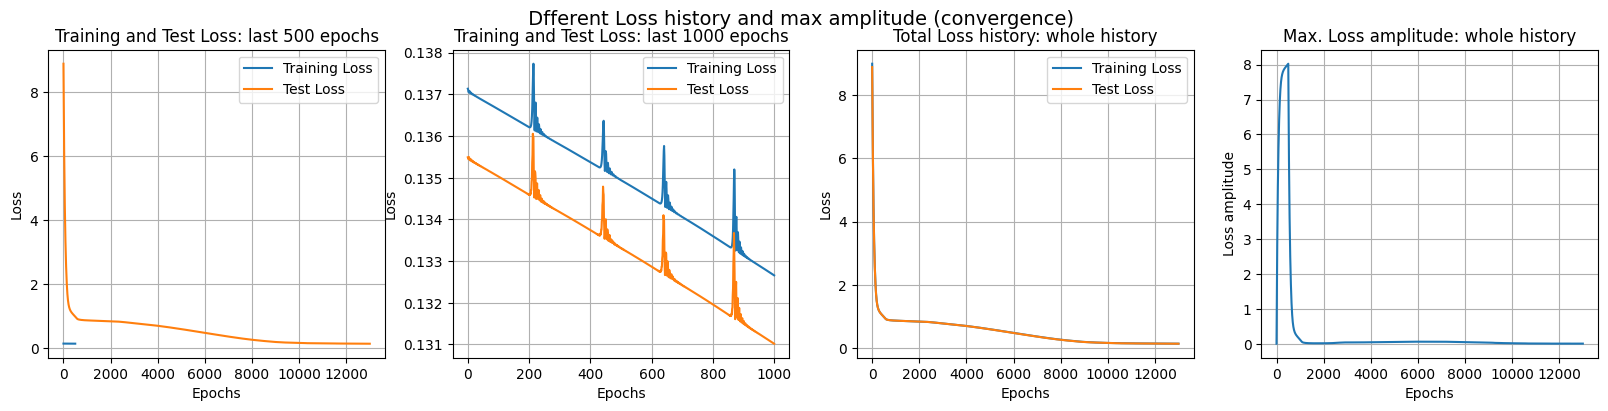

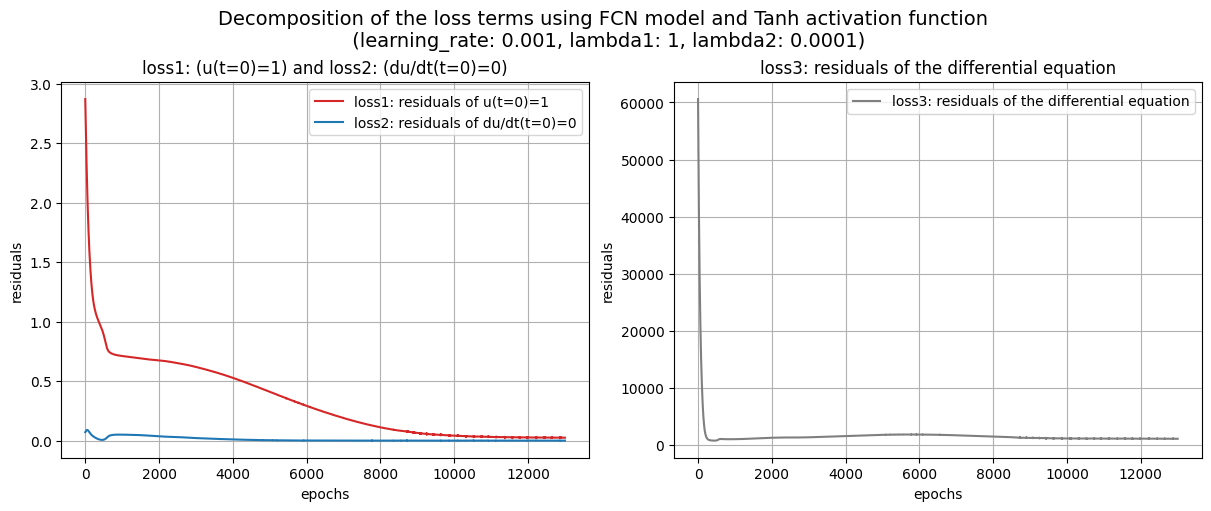

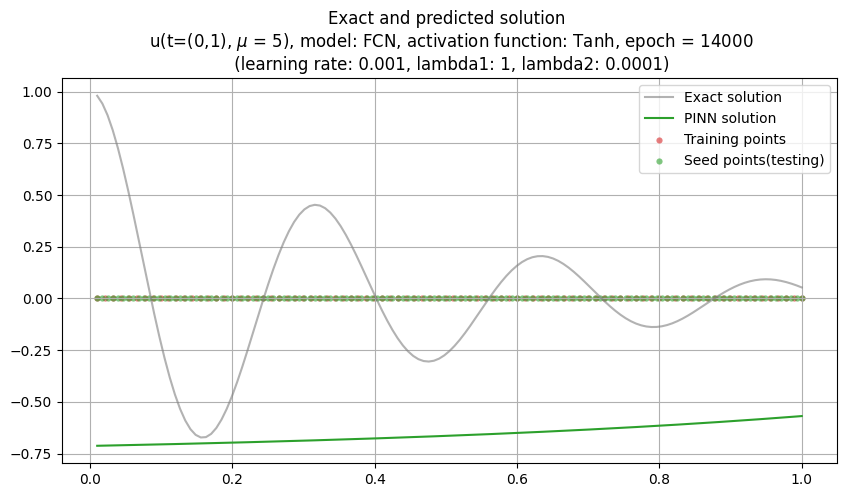

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


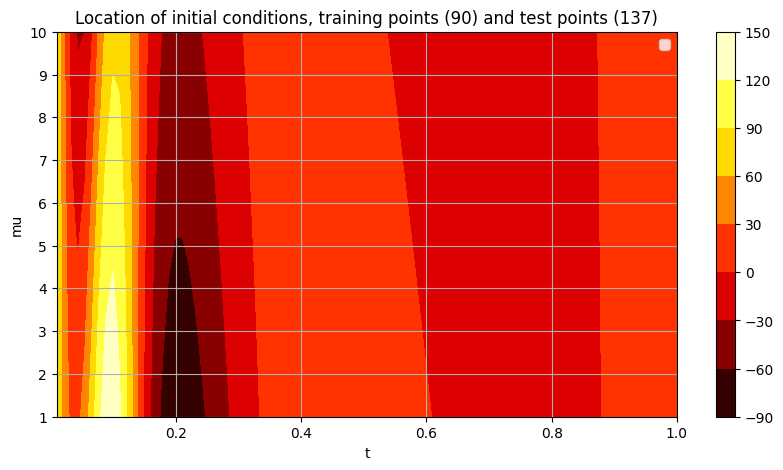

Saved the checkpoint corresponding to epoch: 14000
RESULTS PLOTTED FOR EPOCH: 14000
########################################################################################################################################################################################################
########################################################################################################################################################################################################
PLOTTING THE RESULTS FOR EPOCH: 15000
max_min_amplitude = 0.004750452935695648
Decomposition of the loss terms: 
 loss(0.12030292302370071) = loss1(0.02159411460161209) + 1 * loss2(8.057646482484415e-05) + 0.0001 * loss3(986.2823486328125)


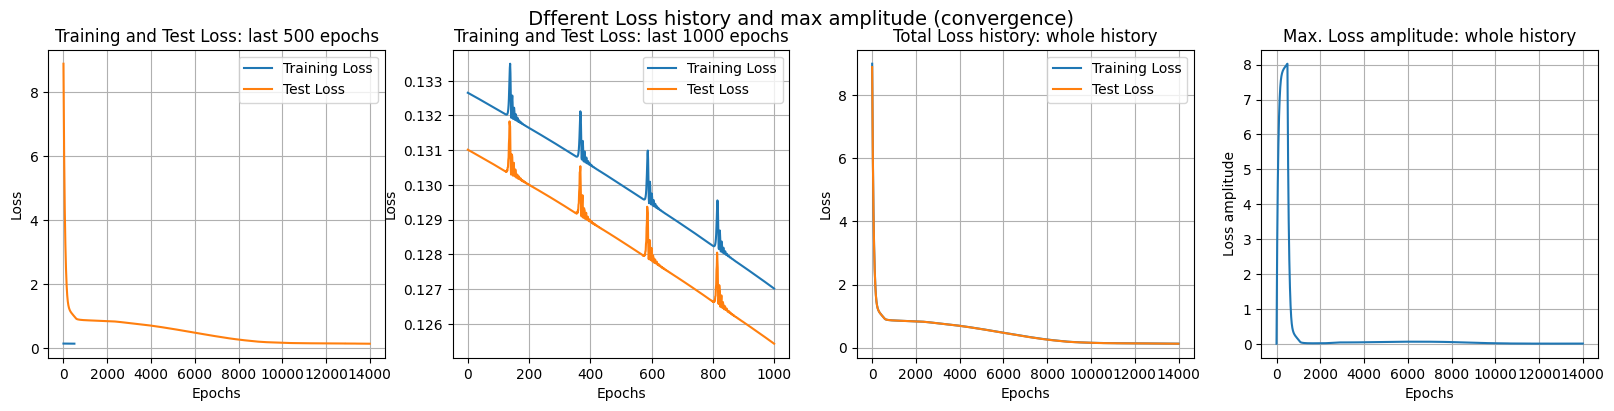

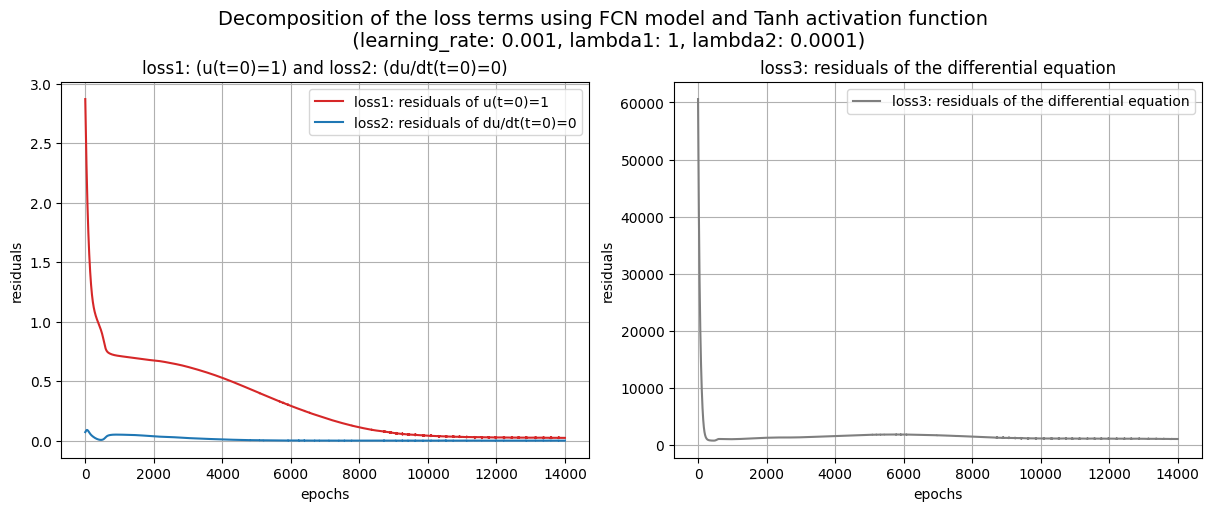

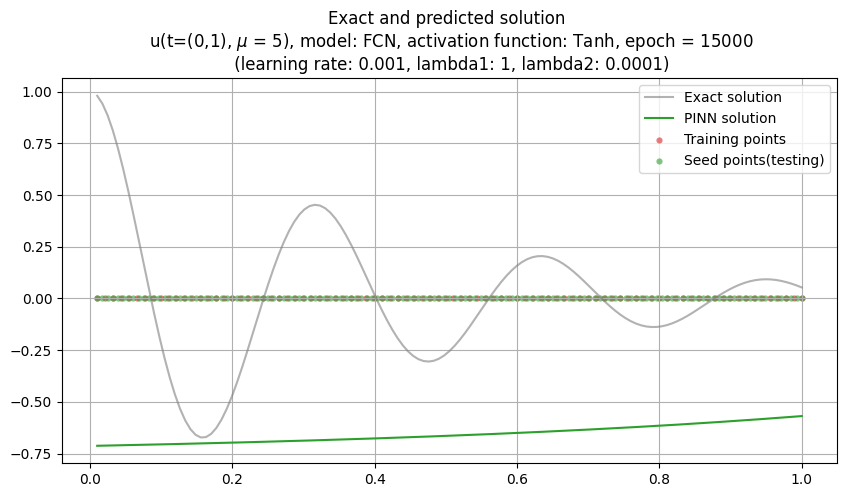

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


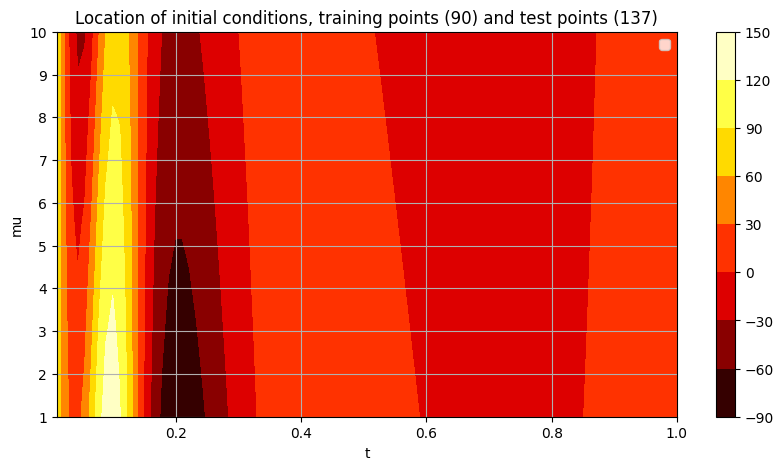

Saved the checkpoint corresponding to epoch: 15000
RESULTS PLOTTED FOR EPOCH: 15000
########################################################################################################################################################################################################
########################################################################################################################################################################################################
PLOTTING THE RESULTS FOR EPOCH: 16000
max_min_amplitude = 0.003969617187976837
Decomposition of the loss terms: 
 loss(0.1130671352148056) = loss1(0.019513186067342758) + 1 * loss2(5.727979078073986e-05) + 0.0001 * loss3(934.9666748046875)


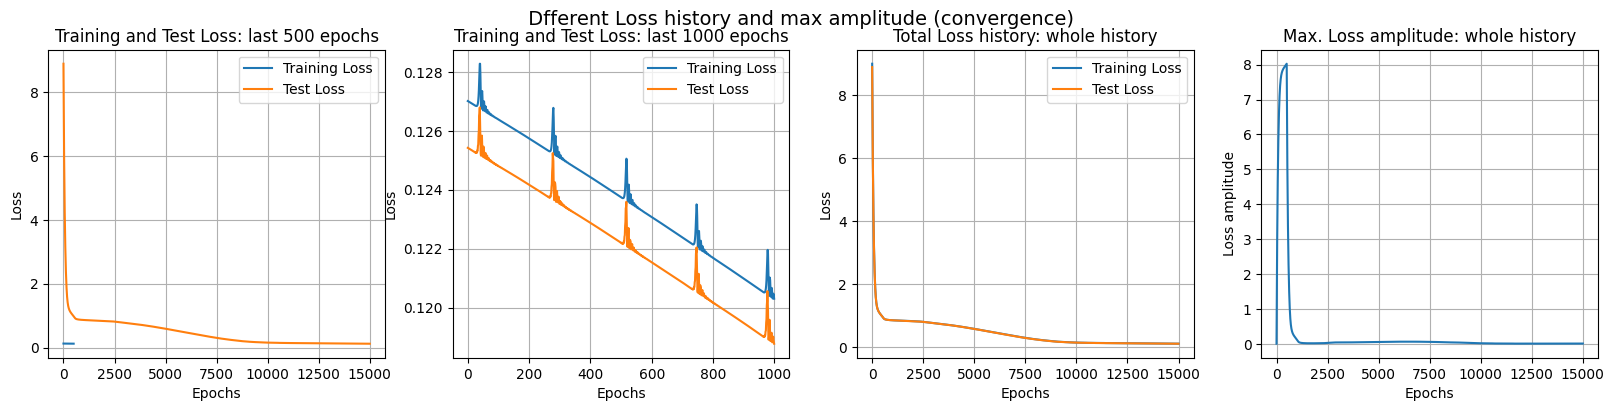

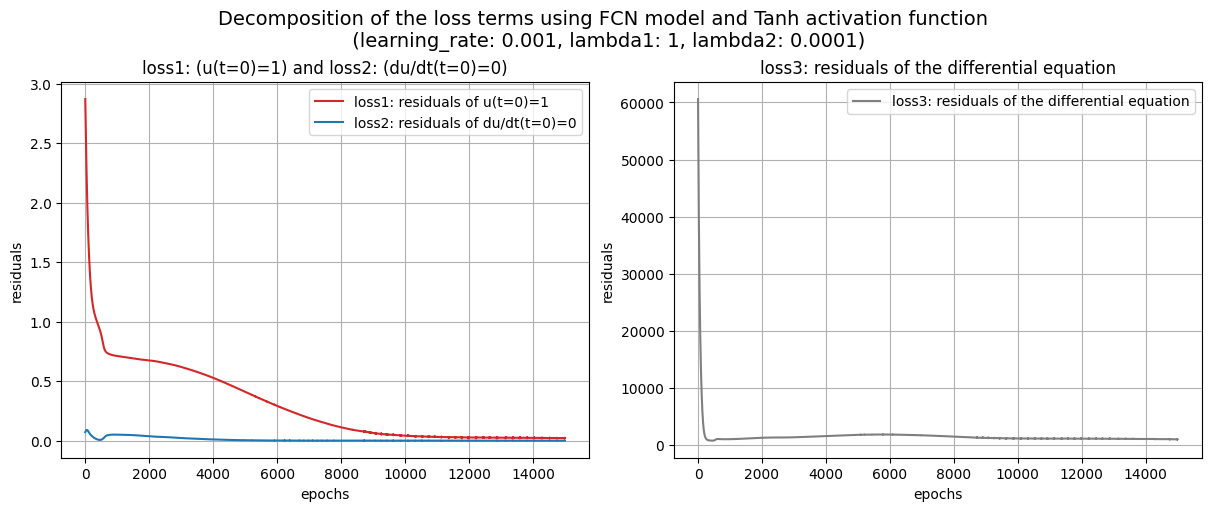

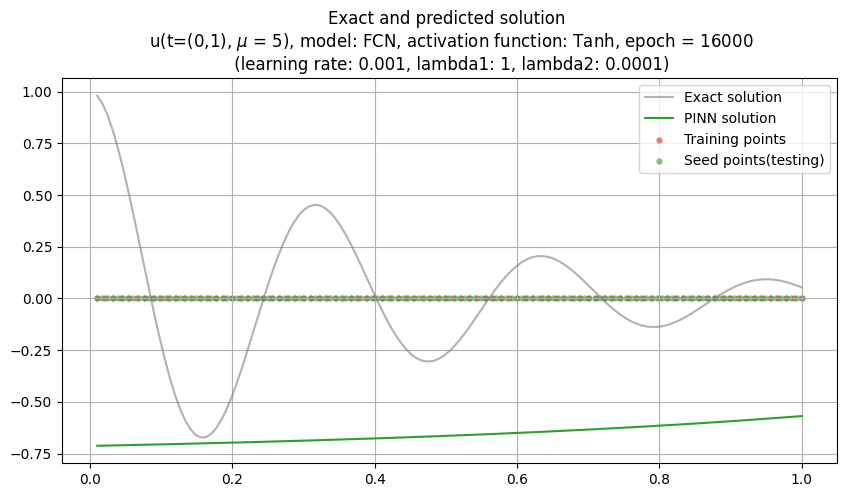

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


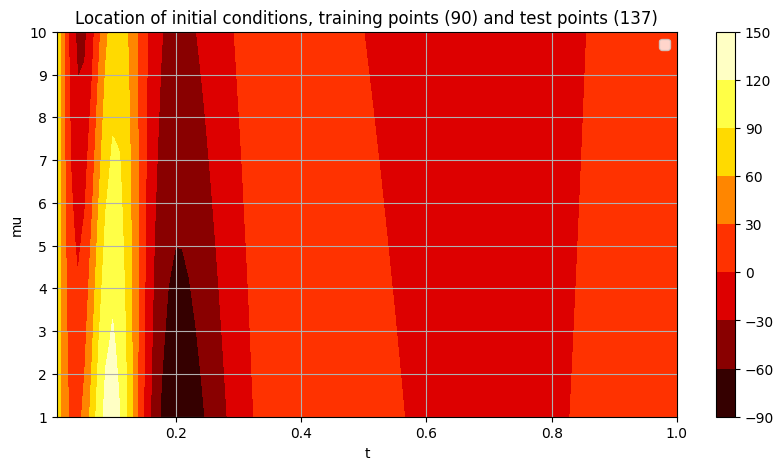

Saved the checkpoint corresponding to epoch: 16000
RESULTS PLOTTED FOR EPOCH: 16000
########################################################################################################################################################################################################
########################################################################################################################################################################################################
PLOTTING THE RESULTS FOR EPOCH: 17000
max_min_amplitude = 0.0038836970925331116
Decomposition of the loss terms: 
 loss(0.10612431913614273) = loss1(0.017797840759158134) + 1 * loss2(8.600572618888691e-05) + 0.0001 * loss3(882.40478515625)


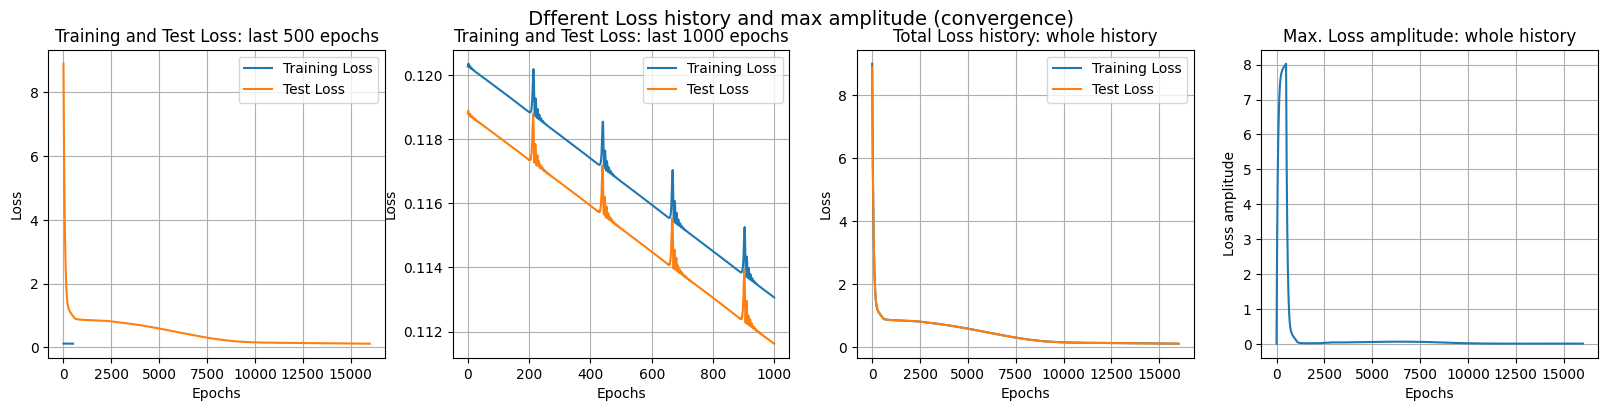

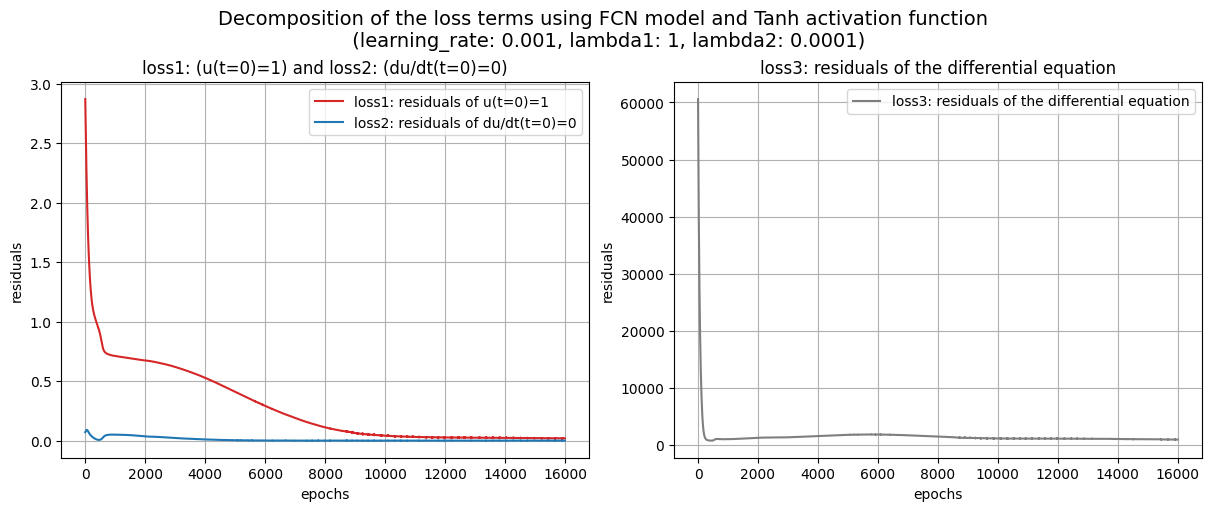

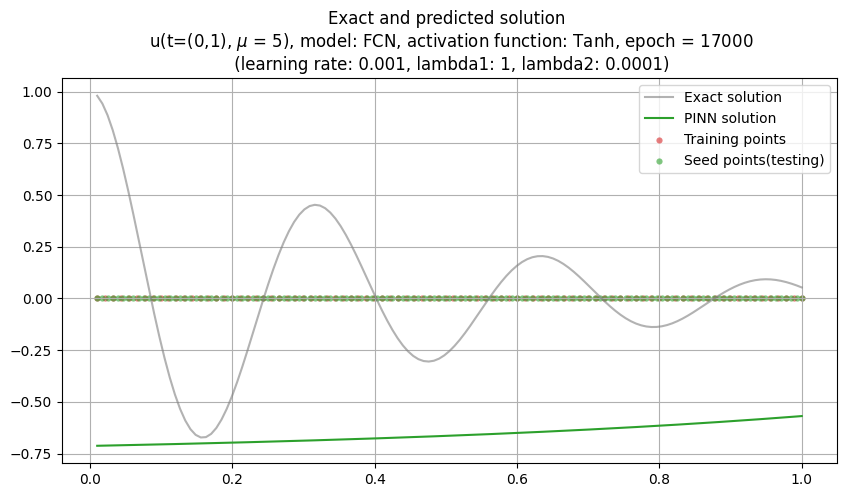

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


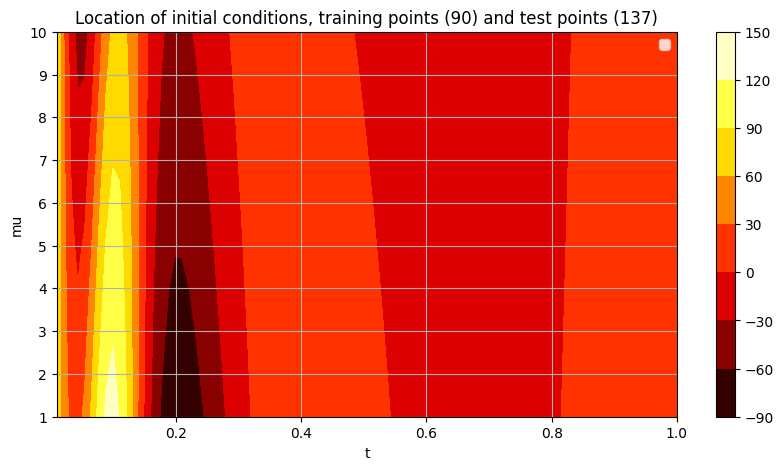

Saved the checkpoint corresponding to epoch: 17000
RESULTS PLOTTED FOR EPOCH: 17000
########################################################################################################################################################################################################
########################################################################################################################################################################################################
PLOTTING THE RESULTS FOR EPOCH: 18000
max_min_amplitude = 0.003994785249233246
Decomposition of the loss terms: 
 loss(0.10002776235342026) = loss1(0.01624109409749508) + 1 * loss2(9.622387733543292e-05) + 0.0001 * loss3(836.9044189453125)


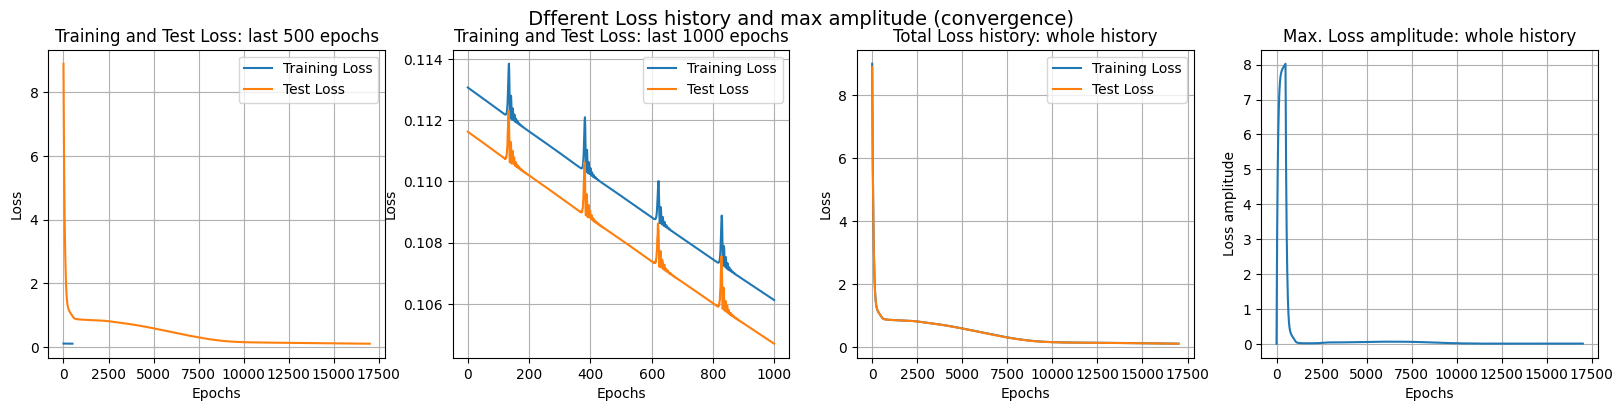

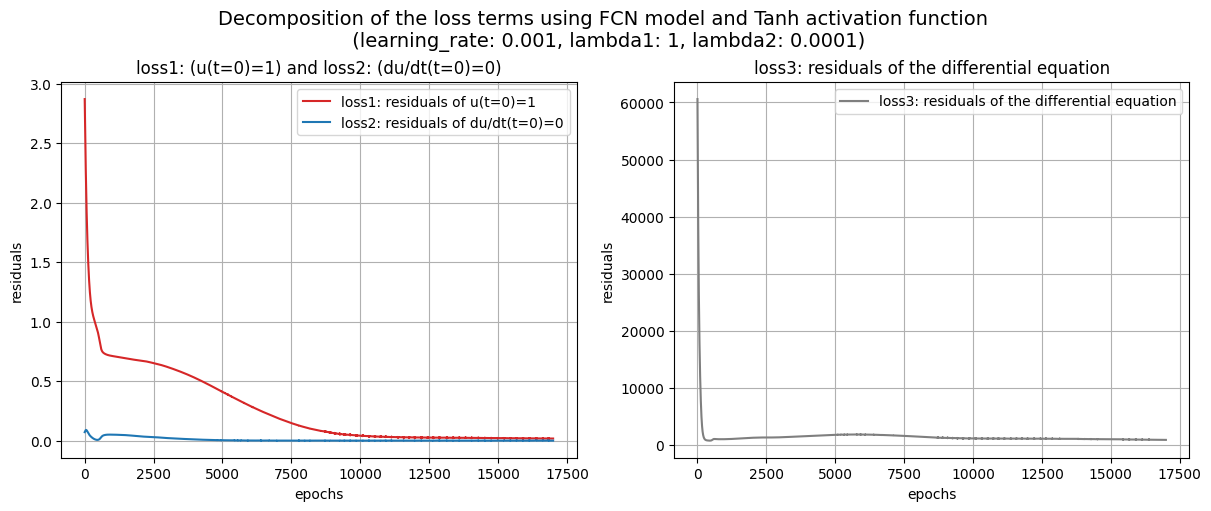

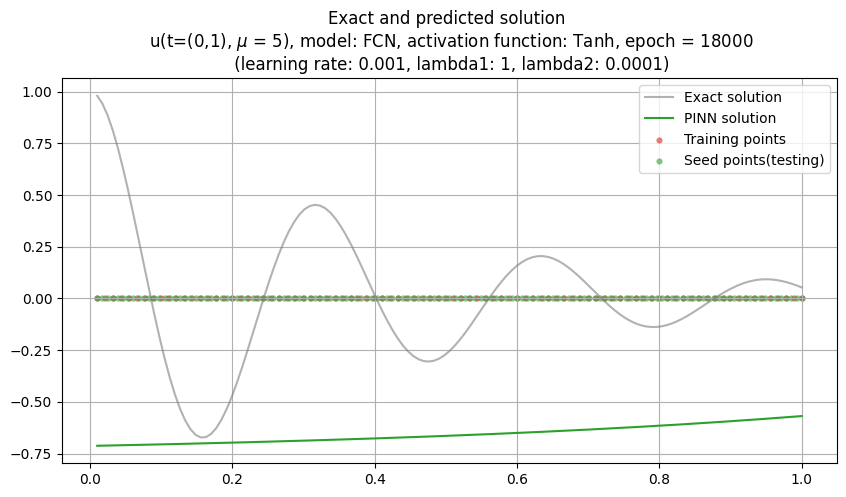

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


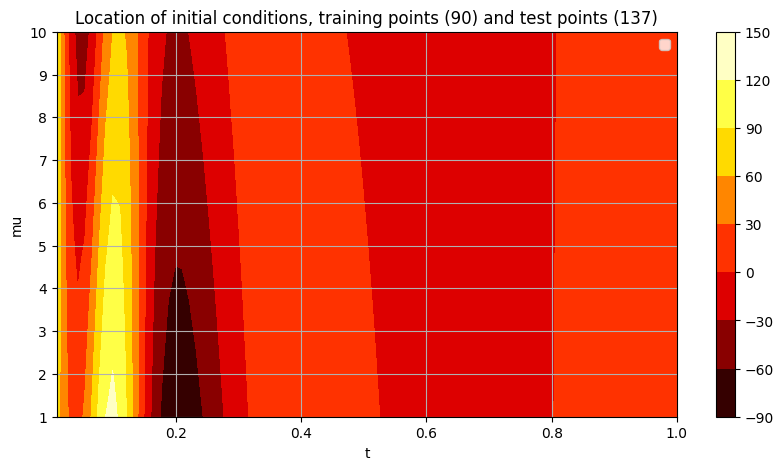

Saved the checkpoint corresponding to epoch: 18000
RESULTS PLOTTED FOR EPOCH: 18000
########################################################################################################################################################################################################
########################################################################################################################################################################################################
PLOTTING THE RESULTS FOR EPOCH: 19000
max_min_amplitude = 0.0033028796315193176
Decomposition of the loss terms: 
 loss(0.09498715400695801) = loss1(0.015016586519777775) + 1 * loss2(0.00011061417899327353) + 0.0001 * loss3(798.599609375)


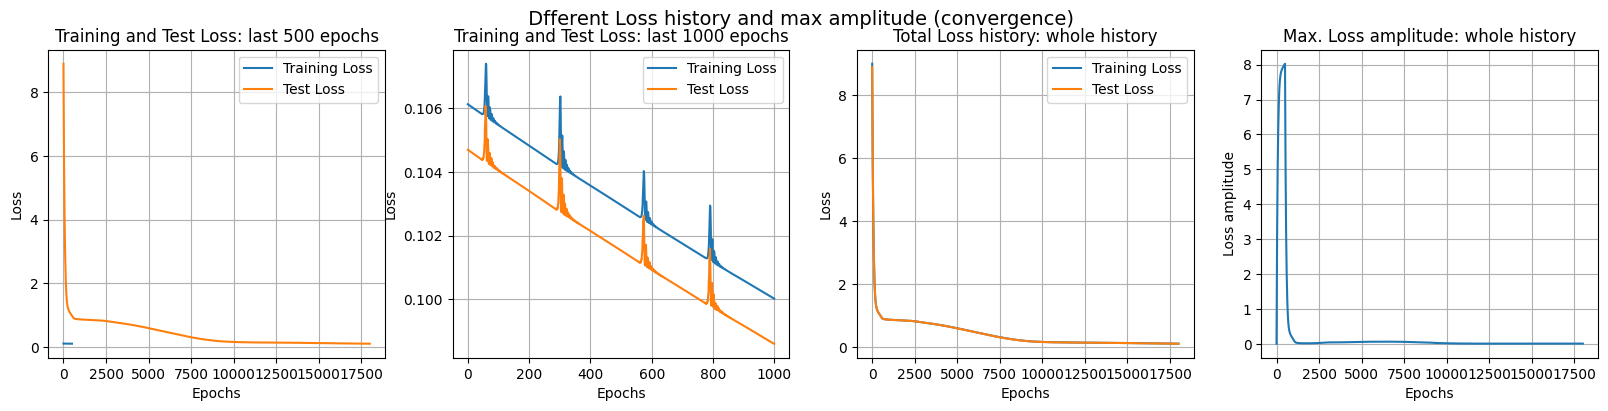

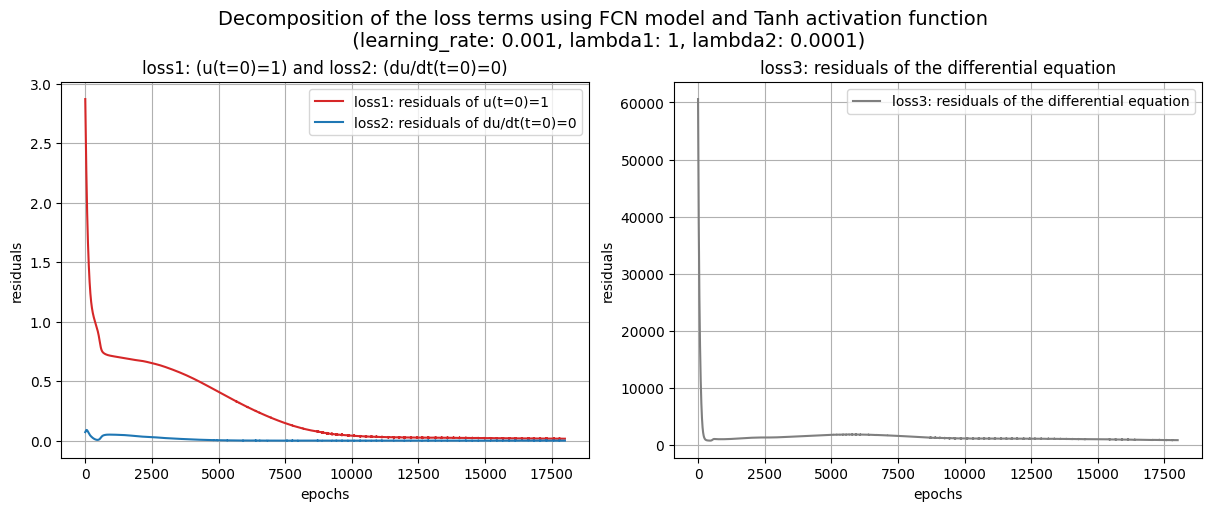

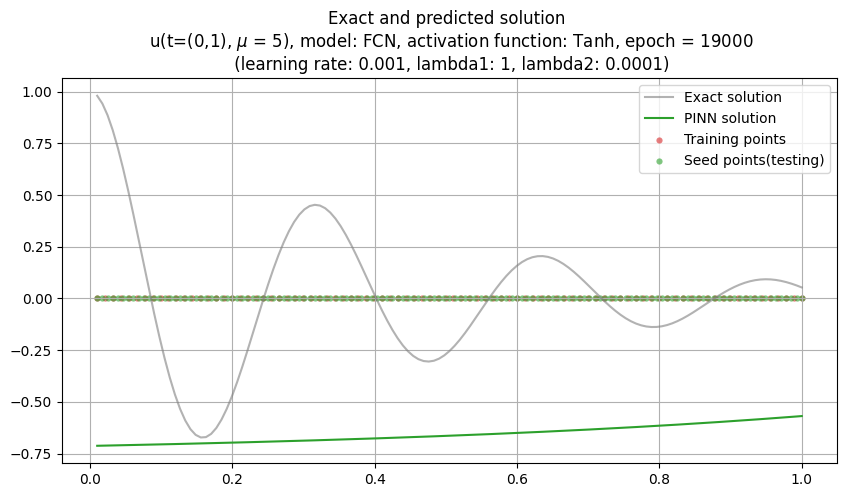

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


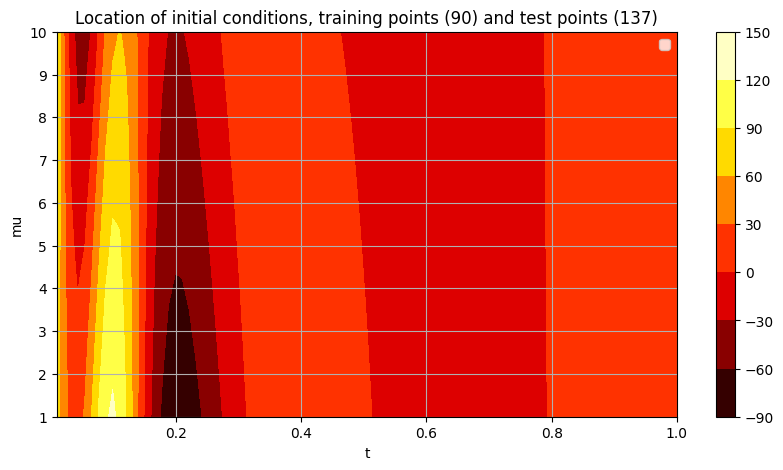

Saved the checkpoint corresponding to epoch: 19000
RESULTS PLOTTED FOR EPOCH: 19000
########################################################################################################################################################################################################
########################################################################################################################################################################################################
PLOTTING THE RESULTS FOR EPOCH: 20000
max_min_amplitude = 0.003626130521297455
Decomposition of the loss terms: 
 loss(0.09092545509338379) = loss1(0.014162816107273102) + 1 * loss2(0.0001681390858720988) + 0.0001 * loss3(765.945068359375)


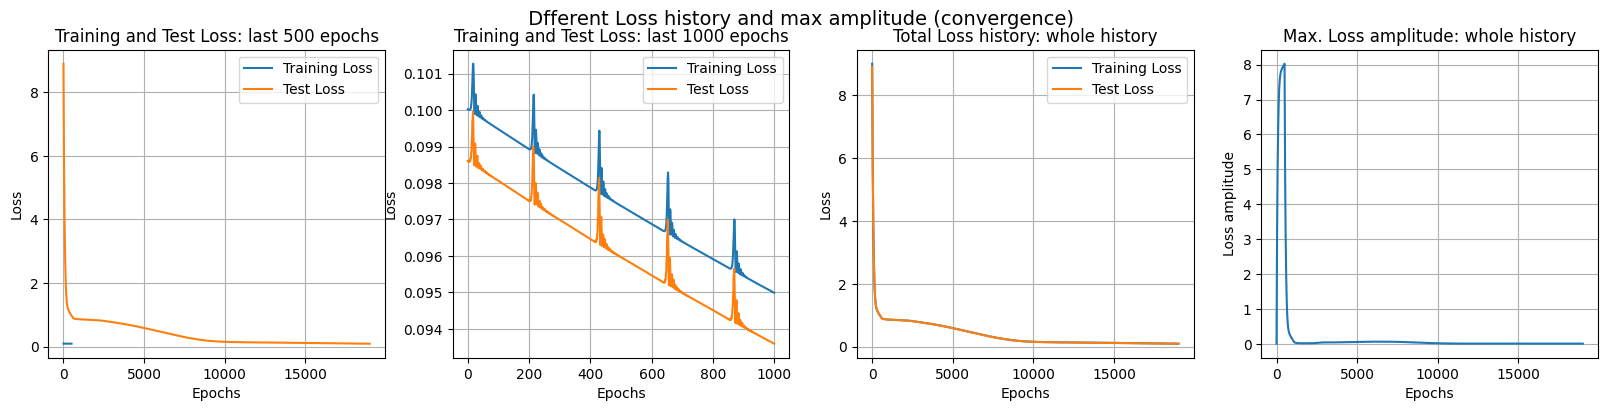

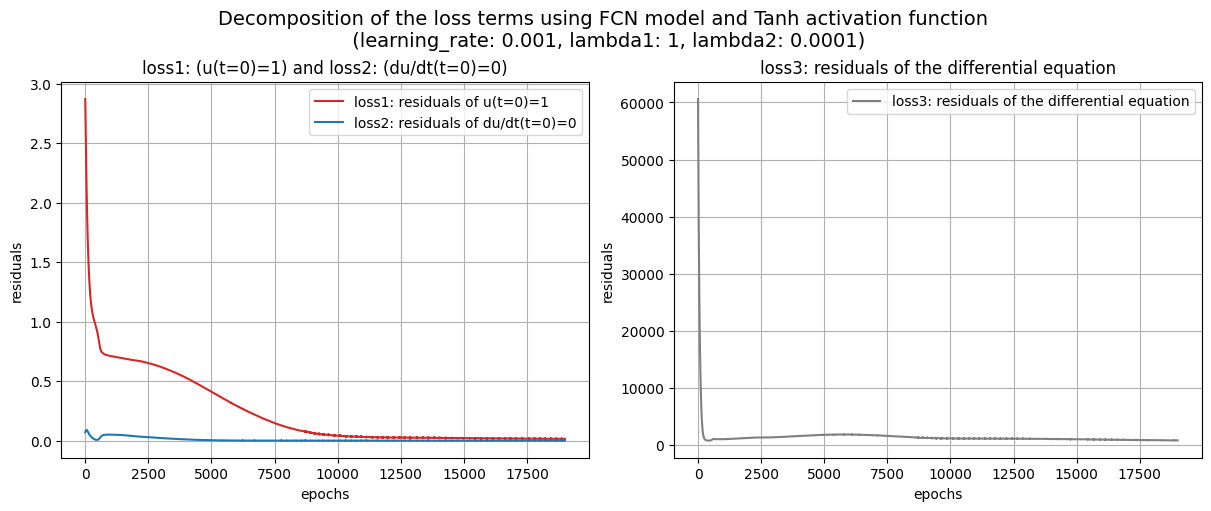

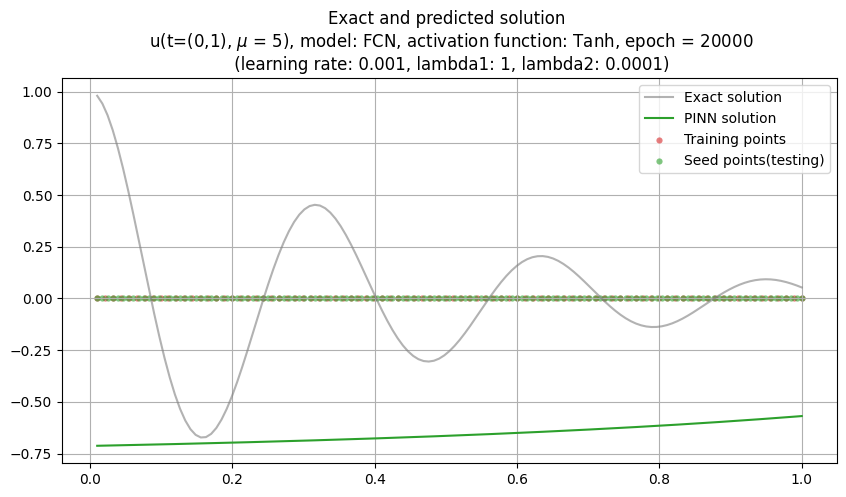

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


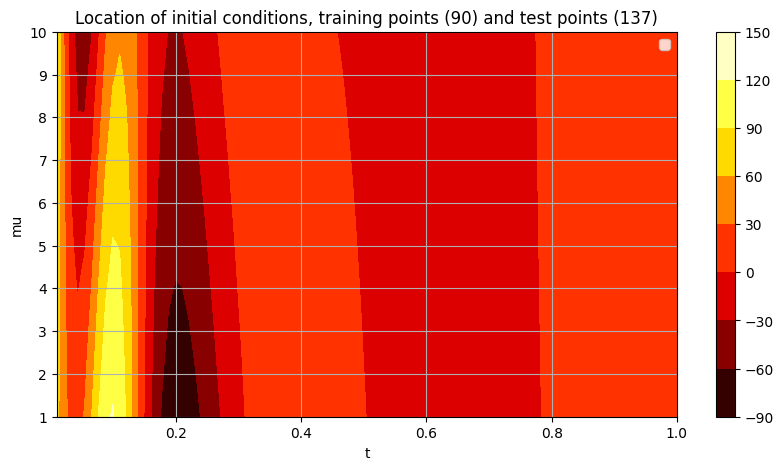

Saved the checkpoint corresponding to epoch: 20000
RESULTS PLOTTED FOR EPOCH: 20000
########################################################################################################################################################################################################
********************************************************************************************************************************************************************************************************
PLOTTING THE RESULTS FOR LAST EPOCH: 20000
max_min_amplitude = 0.003626130521297455
Decomposition of the loss terms: 
 loss(0.09092545509338379) = loss1(0.014162816107273102) + 1 * loss2(0.0001681390858720988) + 0.0001 * loss3(765.945068359375)


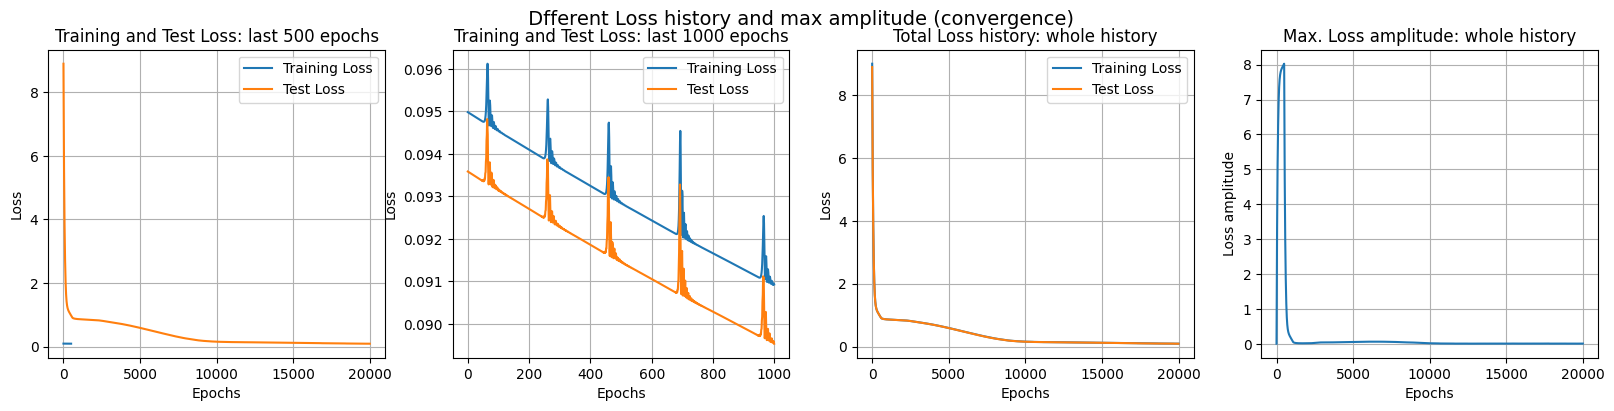

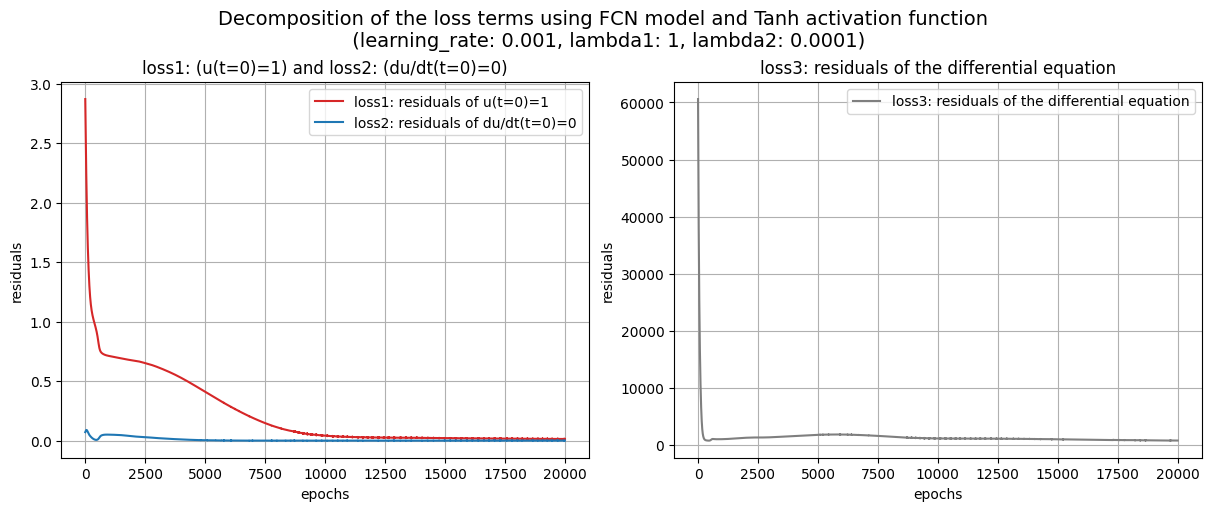

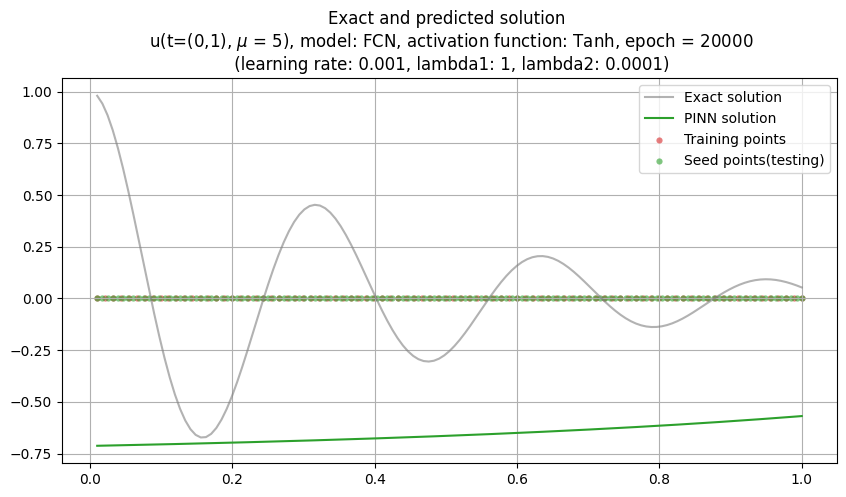

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


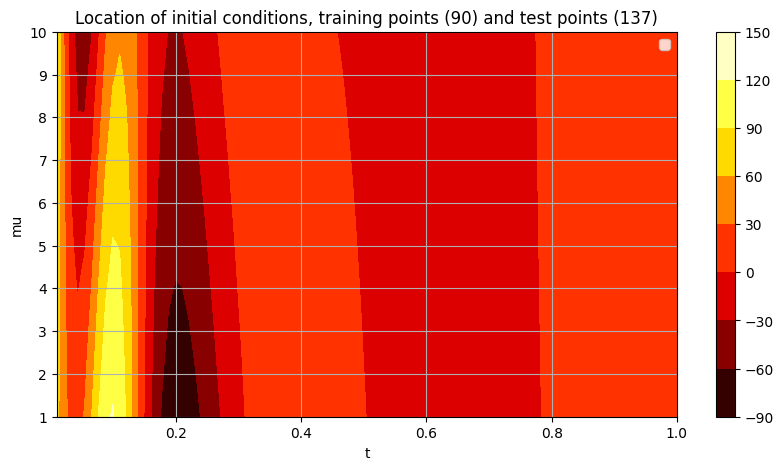

Training elapsed time (s): 157.29596519470215
Saved the checkpoint corresponding to last epoch: 20000


AttributeError: 'TrainModel' object has no attribute 'plot_weights'

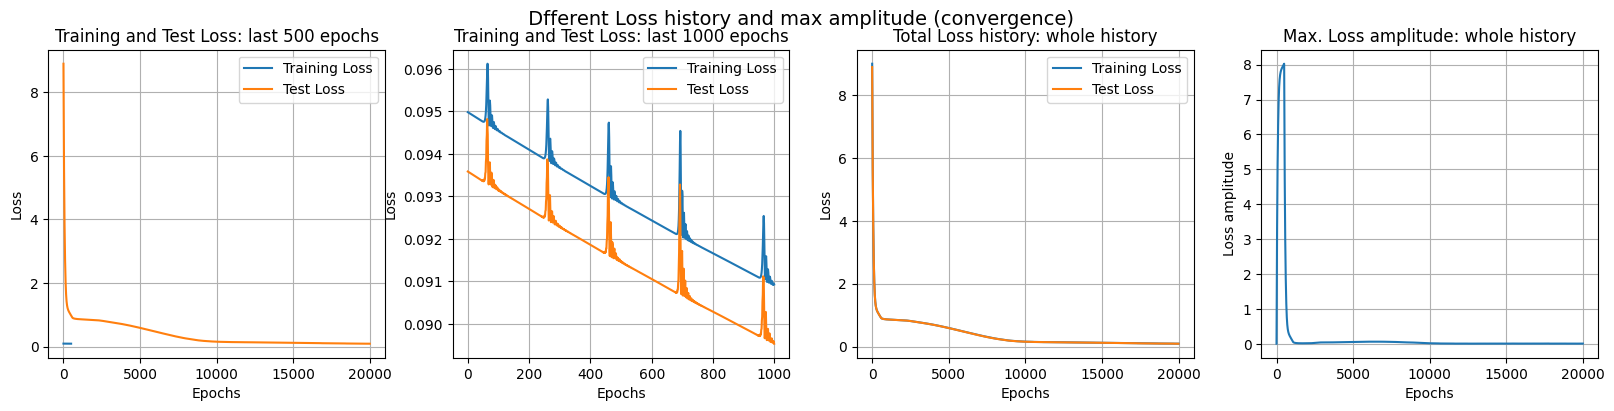

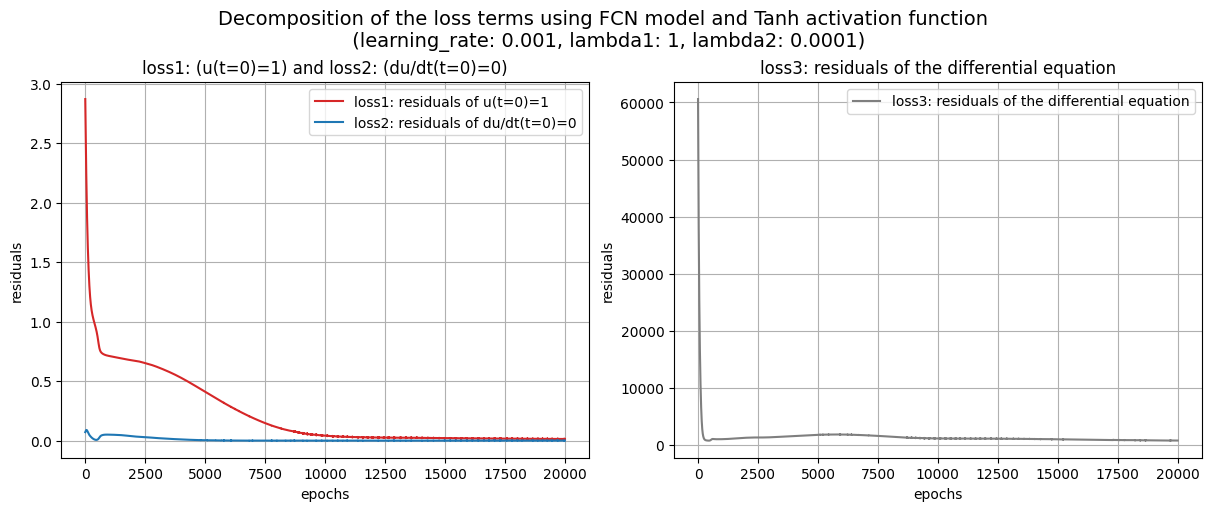

In [11]:
# Train original model
#train_model = TrainModel(original_model, num_epochs=1000, checkpoint_interval=100, loss_threshold=0.01)
#train_model = TrainModel(original_model, ic1_t_mu, ic1_scope, ic2_scope, physic_domain_t_mu, k, learning_rate = 0.0001, num_epochs= 20000, lambda1= 1e-1, lambda2 = 1e-4, checkpoint_interval = 1000, stagnation_amplitude= 0.0001, stagnation_range = 200)
#train_model = TrainModel(original_model, ic1_t_mu, ic1_scope, ic2_scope, physic_in_t_mu, physic_domain_t_mu, k, test_physic_in_t_mu, u_exact, test_mu = 5, learning_rate = 1e-2, num_epochs= 50000, lambda1= 1, lambda2 = 1e-4, checkpoint_interval = 1000, stagnation_amplitude= 0.00001, stagnation_range = 100)
train_model = TrainModel(original_model, ic1_t_mu, ic1_scope, ic2_scope, physic_in_t_mu, physic_domain_t_mu, k, test_ic1_t_mu, test_ic1_scope, test_ic2_t_mu, test_ic2_scope, test_physic_in_t_mu, test_physic_domain_t_mu, u_exact= exact_solution, test_mu = 5, mass = 1, w0 = 20, learning_rate = 0.001, num_epochs= 20000, lambda1= 1, lambda2 = 1e-4, checkpoint_interval = 1000, stagnation_amplitude= 0.0001, stagnation_range = 500)

In [ ]:
original_model.plot_weights(fig_size = (10,5), font_size = 8)

In [ ]:
# Plot the loss history as before
plt.figure(figsize=(5, 3))
plt.plot(train_model.loss_history, label='Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss: last 100 epochs')
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(train_model.loss_total_history[-1000:], label='Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss: last 1000 epochs')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(train_model.loss_total_history, label='Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss: whole history')
plt.legend()
plt.show()

## STEP 5: Investigation of the loss terms

In [ ]:
# plot the contribution of every loss term (loss1, loss2 and loss3)
fig, (loss1_2, loss3) = plt.subplots(1,2, layout = 'constrained', sharex = True, figsize = (12,5))
#fig.suptitle(f"Decomposition of the loss terms using {original_model.__class__.__name__} model and Tanh #{original_model.activation()}# activation function \n (learning_rate: {learning_rate}, lambda1: {lambda1}, lambda2: {lambda2})", fontsize = 14)
fig.suptitle(f"Decomposition of the loss terms using {train_model.__class__.__name__} model and Tanh activation function \n (learning_rate: {train_model.learning_rate}, lambda1: {train_model.lambda1}, lambda2: {train_model.lambda2})", fontsize = 14)

loss1_2.plot(train_model.loss_ic1_history, label = "loss1: residuals of u(t=0)=1", color = "tab:red")
loss1_2.plot(train_model.loss_ic2_history, label = "loss2: residuals of du/dt(t=0)=0", color = "tab:blue")
loss1_2.set_title("loss1: (u(t=0)=1) and loss2: (du/dt(t=0)=0)")
loss1_2.set_xlabel("epochs")
loss1_2.set_ylabel("residuals")
loss1_2.grid()
loss1_2.legend()

loss3.plot(train_model.loss_differential_equation_history, label= "loss3: residuals of the differential equation", color = "tab:grey")
loss3.set_title("loss3: residuals of the differential equation")
loss3.set_xlabel("epochs")
loss3.set_ylabel("residuals")
loss3.legend()
loss3.grid()

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(train_model.max_min_amplitude_history, label='Max min range over epochs')
plt.xlabel('Epochs')
plt.ylabel('Max min range')
plt.title('Max min range: whole history')
plt.legend()
plt.show()

## STEP 6: Inference/Prediction with a constant mu

In [ ]:
test_mu = 5
test_in_t_constant_mu = torch.stack([torch.linspace(0,1,point_resolution_test), test_mu*torch.ones(point_resolution_test)], -1).view(-1,2)
test_in_t_constant_mu.size

In [ ]:
test_predicted = original_model(test_in_t_constant_mu)

In [ ]:
u_exact = exact_solution(test_mu/(2*mass), w0, test_physic_in_t_mu[0])

In [ ]:
#u_test = pinn(test_t_frict_coeff_total).detach().cpu()
plt.figure(figsize=(10,2.5))

plt.plot(test_physic_in_t_mu[0].detach(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6)
plt.plot(test_physic_in_t_mu[0], 
                 test_predicted[:,0].detach(), 
                 label="PINN solution", 
                 color="tab:green")
plt.scatter(
            physic_in_t_mu[0].detach(), 
            torch.zeros_like(physic_in_t_mu[0]), 
            s=20, 
            lw=0, 
            color="tab:red",
            alpha=0.6,
            label= "Training points")
plt.scatter(
            test_physic_in_t_mu[0], 
            torch.zeros_like(test_physic_in_t_mu[0]), 
            s=20, 
            lw=0, 
            color="tab:green",
            alpha=0.6,
            label= "Seed points(testing)")
plt.title(f"Inference Case: Exact and predicted solution \n u(t=(0,1), $\mu$ = {train_model.test_mu}), model: {train_model.__class__.__name__}, activation function: Tanh \n (learning rate: {train_model.learning_rate}, lambda1: {train_model.lambda1}, lambda2: {train_model.lambda2})")
plt.grid()
plt.legend()
plt.show()

# STEP 7: extension of the model

In [ ]:
# Create extended model
extended_input_size = 2
extended_hidden_layers = [4,4]
extended_output_size = 1
extended_model = FCN_extended(extended_input_size, extended_hidden_layers, extended_output_size, activation='Tanh', initialization='Xavier', original_model_path='original_model.pt')

In [ ]:
extended_model.plot_weights(fig_size = (10,5), font_size = 8)

## Inference/Prediction for checking a correct initialization of the extended model

In [ ]:
test_mu = 5
test_in_t_constant_mu = torch.stack([torch.linspace(0,1,point_resolution_test), test_mu*torch.ones(point_resolution_test)], -1).view(-1,2)
test_in_t_constant_mu.size

In [ ]:
test_predicted_extended_model = extended_model(test_in_t_constant_mu)

In [ ]:
u_exact = exact_solution(test_mu/(2*mass), w0, test_physic_in_t_mu[0])

In [ ]:
#u_test = pinn(test_t_frict_coeff_total).detach().cpu()
plt.figure(figsize=(10,2.5))

plt.plot(test_physic_in_t_mu[0].detach(), 
                 u_exact, 
                 label="Exact solution", 
                 color="tab:grey", 
                 alpha=0.6)
plt.plot(test_physic_in_t_mu[0], 
                 test_predicted_extended_model[:,0].detach(), 
                 label="PINN solution", 
                 color="tab:green")
plt.scatter(
            physic_in_t_mu[0].detach(), 
            torch.zeros_like(physic_in_t_mu[0]), 
            s=20, 
            lw=0, 
            color="tab:red",
            alpha=0.6,
            label= "Training points")
plt.scatter(
            test_physic_in_t_mu[0], 
            torch.zeros_like(test_physic_in_t_mu[0]), 
            s=20, 
            lw=0, 
            color="tab:green",
            alpha=0.6,
            label= "Seed points(testing)")
plt.title(f"Inference Case: Exact and predicted solution \n u(t=(0,1), $\mu$ = {train_model.test_mu}), model: {train_model.__class__.__name__}, activation function: Tanh \n (learning rate: {train_model.learning_rate}, lambda1: {train_model.lambda1}, lambda2: {train_model.lambda2})")
plt.grid()
plt.legend()
plt.show()